<a href="https://colab.research.google.com/github/Joeycooky/CV2/blob/master/EDA_Joe_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import Libraries

!pip install --upgrade scikit-learn
!pip install -U imbalanced-learn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

sns.set_context(context='talk')
sns.set_style('white')
%config InlineBackend.figure_format = 'retina'

%matplotlib inline

     |████████████████████████████████| 22.3MB 1.3MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 215kB 5.2MB/s 
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3


## Trap information

In [1]:
!gdown --id 19cou1y5flR2TKObjEK0Cx7qrDjonA4a1 
!gdown --id 1kE1yWsEJpT-Y07fNm14DpiwLwRzTusuD 
!gdown --id 189-e-6zSbm5Sz3ptTNFFfAODbbRLhY9I 
!gdown --id 1VfKf3ajelimSfJzRZRcjUQsyqUoZ4C8C

Downloading...
From: https://drive.google.com/uc?id=19cou1y5flR2TKObjEK0Cx7qrDjonA4a1
To: /content/train.csv
100% 1.80M/1.80M [00:00<00:00, 28.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kE1yWsEJpT-Y07fNm14DpiwLwRzTusuD
To: /content/test.csv
20.0MB [00:00, 42.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=189-e-6zSbm5Sz3ptTNFFfAODbbRLhY9I
To: /content/weather.csv
100% 358k/358k [00:00<00:00, 5.62MB/s]
Downloading...
From: https://drive.google.com/uc?id=1VfKf3ajelimSfJzRZRcjUQsyqUoZ4C8C
To: /content/spray.csv
100% 796k/796k [00:00<00:00, 12.6MB/s]


In [2]:
df_trap = pd.read_csv('/content/train.csv')

#Convert date into datetime object for further comparison and filtering
df_trap['Date'] = pd.to_datetime(df_trap['Date'])

#Drop Address, Block, Street, AddressNumberAndStreet, sine we've already got the geographical coordinates
df_trap = df_trap.drop(columns=['Address','Block','Street','AddressNumberAndStreet'])

df_trap.head()

NameError: ignored

### Deciding which weather station will be used for each trap

Weather information at the nearest station will be used for each observation, therefore, we need to calculate the distance from each weather station with following information

- Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
- Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

For distance calculation, we'll use the empirical estimation of 1° = 111 km  (or 60 nautical miles)

In [ ]:
# Distance calculation 1° = 111 km  (or 60 nautical miles)
lat_s1 = 41.995
long_s1 = -87.933
lat_s2 = 41.786
long_s2 = -87.752

df_trap['Distance_from_s1_km'] = np.sqrt(np.power(60*(df_trap['Latitude']- lat_s1),2)+
                                         np.power(60*(df_trap['Longitude']- long_s1),2))* 111/60 #*111/60 to convert from NM to km

df_trap['Distance_from_s2_km'] = np.sqrt(np.power(60*(df_trap['Latitude']- lat_s2),2)+
                                         np.power(60*(df_trap['Longitude']- long_s2),2))* 111/60 #*111/60 to convert from NM to km

#Select dominant weather station
df_trap['Station'] =df_trap.apply(lambda row: 2 if (row['Distance_from_s1_km'] > row['Distance_from_s2_km']) else 1 , axis = 1)

In [ ]:
df_trap.head()

## Weather information

- Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
- Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

In [ ]:
df_weather = pd.read_csv('/content/weather.csv')
#Convert Date into Datetime object
df_weather['Date'] = pd.to_datetime(df_weather['Date'])

#Convert Data types to one that suitable for our analysis
df_weather['PrecipTotal'] = df_weather['PrecipTotal'].map(lambda s: -1 if s.strip().isalpha() else float(s))
df_weather['WetBulb'] = df_weather['WetBulb'].map(lambda s: -1 if s.strip().isalpha() else float(s))
df_weather['Heat'] = df_weather['Heat'].map(lambda s: -1 if s.strip().isalpha() else float(s))
df_weather['Cool'] = df_weather['Cool'].map(lambda s: -1 if s.strip().isalpha() else float(s))
df_weather['StnPressure'] = df_weather['StnPressure'].map(lambda s: -1 if s.strip().isalpha() else float(s))
df_weather['SeaLevel'] = df_weather['SeaLevel'].map(lambda s: -1 if s.strip().isalpha() else float(s))
df_weather['Tavg'] = df_weather['Tavg'].map(lambda s: -1 if s.strip().isalpha() else float(s))
df_weather['Depart'] = df_weather['Depart'].map(lambda s: 0 if s.strip().isalpha() else float(s))

#Feature engineering
df_weather['%RH'] = 100 - (25/9)*(df_weather['Tavg'] - df_weather['DewPoint'])
df_weather['Tdiff'] = df_weather['Tmax'] - df_weather['Tmin']


#Divide weather data into 2 dataframe according to weather station

weather_1 = df_weather[df_weather['Station'] == 1].set_index('Date')
weather_2 = df_weather[df_weather['Station'] == 2].set_index('Date')


### Feature Engineering on Station 1 data

Motivation: [Mosquito life cycle](https://www.cdc.gov/dengue/resources/factsheets/mosquitolifecyclefinal.pdf)
- The entire life cycle, from an egg to an adult, takes approximately 8-10 days.
- Female mosquitoes lay eggs inside containers holding water.



In [ ]:
#Count the number of days since the last rain,
days_since_last_rain = []
count = 0
for rain in weather_1['PrecipTotal'] :
    if rain <= 0:
        count += 1
        days_since_last_rain.append(count)
    if rain > 0:
        count = 0
        days_since_last_rain.append(count)
        
days_since_last_rain = pd.Series(days_since_last_rain,index=weather_1.index,name='days_since_last_rain')

In [ ]:
#10 days lagged with Exponential Weighted Mean smoothening
d10ewm_Tavg = weather_1.Tavg.shift(10).resample('D').mean().ewm(span=10).mean().rename('10ewm_Tavg')
d10ewm_Tdiff = weather_1.Tdiff.shift(10).resample('D').mean().ewm(span=10).mean().rename('10ewm_Tdiff')
d10ewm_Tmax = weather_1.Tmax.shift(10).resample('D').mean().ewm(span=10).mean().rename('10ewm_Tmax')
d10ewm_Tmin = weather_1.Tmin.shift(10).resample('D').mean().ewm(span=10).mean().rename('10ewm_Tmin')
d10ewm_RH = weather_1['%RH'].shift(10).resample('D').mean().ewm(span=10).mean().rename('10ewm_RH')

#Combine engineered features into the original dataframe
weather_1 = pd.concat([weather_1,
                       d10ewm_Tavg,
                       d10ewm_Tdiff,
                       d10ewm_Tmax,
                       d10ewm_Tmin,
                       d10ewm_RH,
                       days_since_last_rain]
                      ,axis=1)
weather_1 = weather_1.dropna(subset=['Station'])
weather_1['10ewm_Tavg'] = weather_1['10ewm_Tavg'].fillna(weather_1['Tavg'])
weather_1['10ewm_Tdiff'] = weather_1['10ewm_Tdiff'].fillna(weather_1['Tdiff'])
weather_1['10ewm_Tmax'] = weather_1['10ewm_Tmax'].fillna(weather_1['Tmax'])
weather_1['10ewm_Tmin'] = weather_1['10ewm_Tmin'].fillna(weather_1['Tmin'])
weather_1['10ewm_RH'] = weather_1['10ewm_RH'].fillna(weather_1['%RH'])

The raw %RH itselt can't simply be a good predictor. Therefore, we decide to binning it and observe the result.

In [ ]:
#Binning 10erw_rh
def bin_rh(row):
    if row < 50:
        return 1
    elif row < 60:
        return 2
    elif row < 70:
        return 3
    else:
        return 4
weather_1['10ewm_RH_bin'] = weather_1['10ewm_RH'].map(bin_rh)

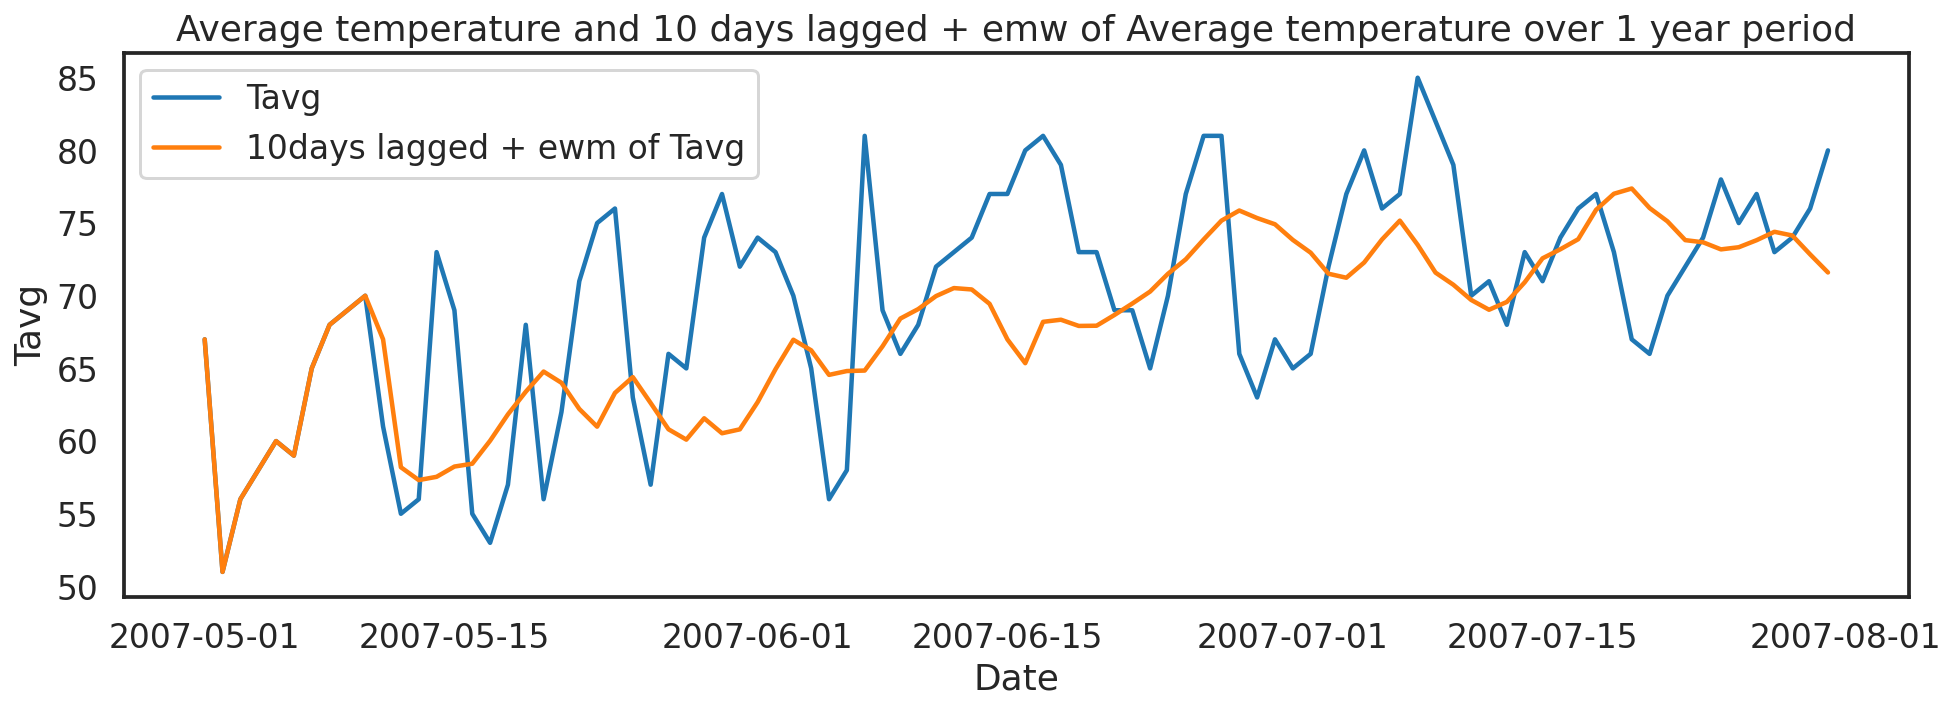

In [ ]:
#@title Default title text
plt.figure(figsize=(16,5))
g = sns.lineplot(data=weather_1[(weather_1.index.year == 2007) & (weather_1.index.month < 8 )], x = 'Date', y='Tavg')
g = sns.lineplot(data=weather_1[(weather_1.index.year == 2007) & (weather_1.index.month < 8)], x = 'Date', y='10ewm_Tavg')
plt.legend(['Tavg','10days lagged + ewm of Tavg'])
plt.title('Average temperature and 10 days lagged + emw of Average temperature over 1 year period');

### Feature Engineering on Station 2 data

we employ the same feature engineering process on weather data of station 2.

In [ ]:
#Count the number of days since the last rain,
days_since_last_rain = []
count = 0
for rain in weather_2['PrecipTotal'] :
    if rain <= 0:
        count += 1
        days_since_last_rain.append(count)
    if rain > 0:
        count = 0
        days_since_last_rain.append(count)
        
days_since_last_rain = pd.Series(days_since_last_rain,index=weather_2.index,name='days_since_last_rain')

In [ ]:
#10 days lagged with Exponential Weighted Mean smoothening
d10ewm_Tavg = weather_2.Tavg.shift(10).resample('D').mean().ewm(span=10).mean().rename('10ewm_Tavg')
d10ewm_Tdiff = weather_2.Tdiff.shift(10).resample('D').mean().ewm(span=10).mean().rename('10ewm_Tdiff')
d10ewm_Tmax = weather_2.Tmax.shift(10).resample('D').mean().ewm(span=10).mean().rename('10ewm_Tmax')
d10ewm_Tmin = weather_2.Tmin.shift(10).resample('D').mean().ewm(span=10).mean().rename('10ewm_Tmin')
d10ewm_RH = weather_2['%RH'].shift(10).resample('D').mean().ewm(span=10).mean().rename('10ewm_RH')

#Combine engineered features into the original dataframe
weather_2 = pd.concat([weather_2,
                       d10ewm_Tavg,
                       d10ewm_Tdiff,
                       d10ewm_Tmax,
                       d10ewm_Tmin,
                       d10ewm_RH,
                       days_since_last_rain]
                      ,axis=1)
weather_2 = weather_2.dropna(subset=['Station'])
weather_2['10ewm_Tavg'] = weather_2['10ewm_Tavg'].fillna(weather_2['Tavg'])
weather_2['10ewm_Tdiff'] = weather_2['10ewm_Tdiff'].fillna(weather_2['Tdiff'])
weather_2['10ewm_Tmax'] = weather_2['10ewm_Tmax'].fillna(weather_2['Tmax'])
weather_2['10ewm_Tmin'] = weather_2['10ewm_Tmin'].fillna(weather_2['Tmin'])
weather_2['10ewm_RH'] = weather_2['10ewm_RH'].fillna(weather_2['%RH'])
weather_2['10ewm_RH_bin'] = weather_2['10ewm_RH'].map(bin_rh)

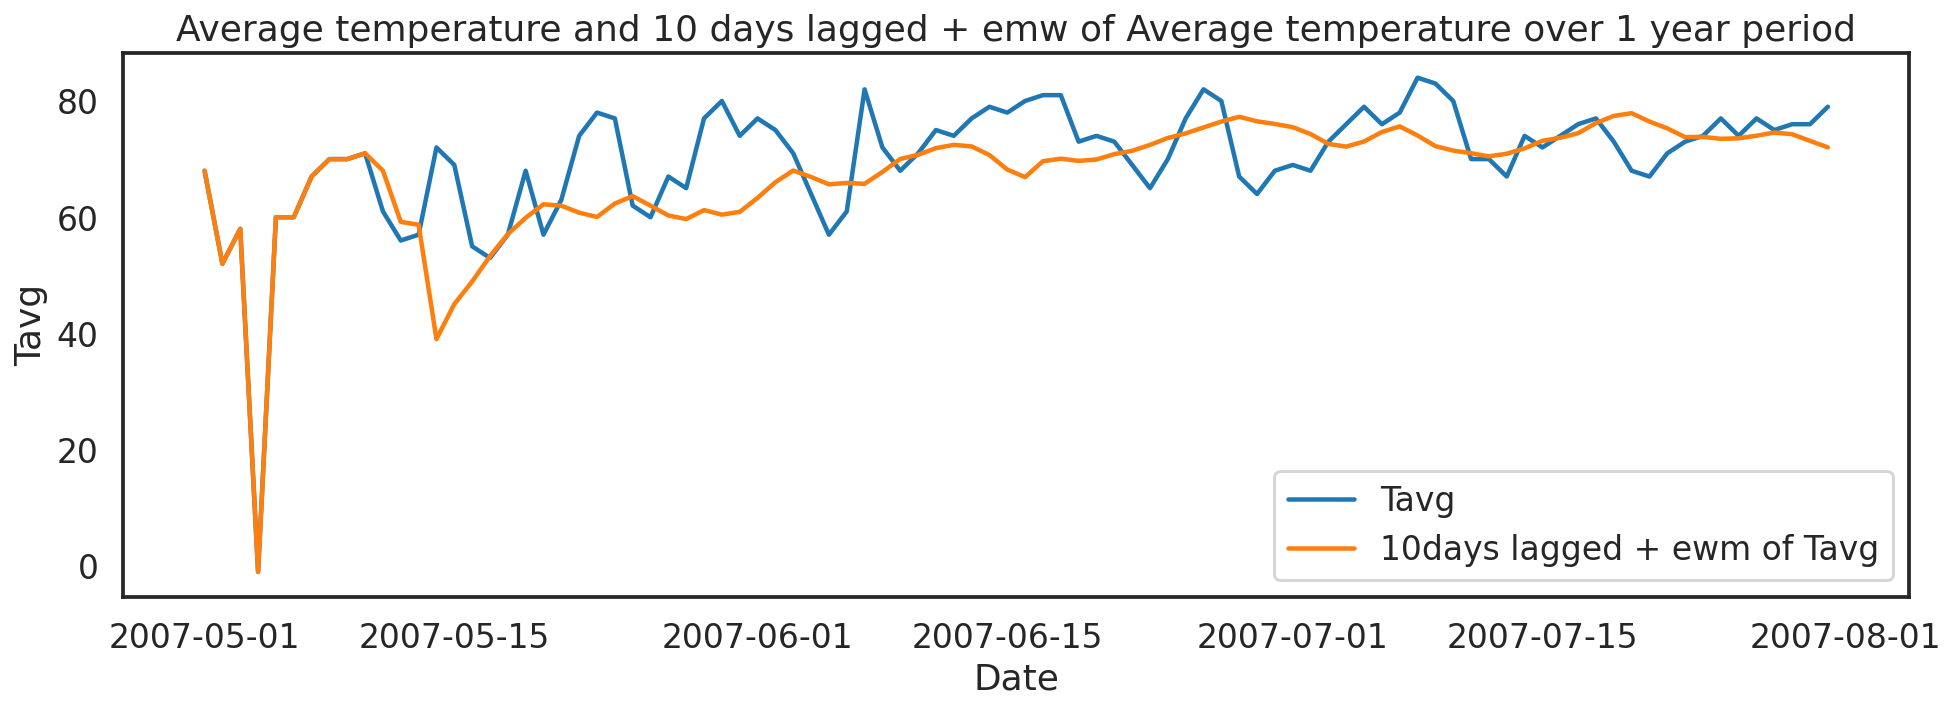

In [ ]:
#@title Default title text { display-mode: "code" }
plt.figure(figsize=(16,5))
g = sns.lineplot(data=weather_2[(weather_2.index.year == 2007) & (weather_2.index.month < 8 )], x = 'Date', y='Tavg')
g = sns.lineplot(data=weather_2[(weather_2.index.year == 2007) & (weather_2.index.month < 8)], x = 'Date', y='10ewm_Tavg')
plt.legend(['Tavg','10days lagged + ewm of Tavg'])
plt.title('Average temperature and 10 days lagged + emw of Average temperature over 1 year period');

In [ ]:
df_weather = pd.concat([weather_1,weather_2]).sort_index()

## Merged Trap and Weather data into single dataframe

In [ ]:
#Merging related weather information to the trap dataframe
df_merged = pd.merge(df_trap,df_weather,left_on=['Date','Station'],right_on=['Date','Station'])

#Extract Year and Month to separated features to see if there is any temporal relationship
df_merged['Year'] = df_merged['Date'].dt.year
df_merged['Month'] = df_merged['Date'].dt.month

df_merged.head()

,Date,Species,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Distance_from_s1_km,Distance_from_s2_km,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,%RH,Tdiff,10ewm_Tavg,10ewm_Tdiff,10ewm_Tmax,10ewm_Tmin,10ewm_RH,days_since_last_rain,10ewm_RH_bin,Year,Month
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,9,1,0,15.320924,19.498260,1,88.0,60.0,74.0,10.0,58.0,65.0,0.0,9.0,0421,1917,BR HZ,0,M,0.0,0.0,29.39,30.11,5.8,18.0,6.5,55.555556,28.0,61.568361,24.105318,73.399798,49.29448,40.249808,2.0,1,2007,5
1,2007-05-29,CULEX RESTUANS,T002,41.954690,-87.800991,9,1,0,15.320924,19.498260,1,88.0,60.0,74.0,10.0,58.0,65.0,0.0,9.0,0421,1917,BR HZ,0,M,0.0,0.0,29.39,30.11,5.8,18.0,6.5,55.555556,28.0,61.568361,24.105318,73.399798,49.29448,40.249808,2.0,1,2007,5
2,2007-05-29,CULEX RESTUANS,T007,41.994991,-87.769279,9,1,0,18.173031,23.277153,1,88.0,60.0,74.0,10.0,58.0,65.0,0.0,9.0,0421,1917,BR HZ,0,M,0.0,0.0,29.39,30.11,5.8,18.0,6.5,55.555556,28.0,61.568361,24.105318,73.399798,49.29448,40.249808,2.0,1,2007,5
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,8,1,0,12.231129,22.387646,1,88.0,60.0,74.0,10.0,58.0,65.0,0.0,9.0,0421,1917,BR HZ,0,M,0.0,0.0,29.39,30.11,5.8,18.0,6.5,55.555556,28.0,61.568361,24.105318,73.399798,49.29448,40.249808,2.0,1,2007,5
4,2007-05-29,CULEX RESTUANS,T015,41.974089,-87.824812,8,4,0,12.231129,22.387646,1,88.0,60.0,74.0,10.0,58.0,65.0,0.0,9.0,0421,1917,BR HZ,0,M,0.0,0.0,29.39,30.11,5.8,18.0,6.5,55.555556,28.0,61.568361,24.105318,73.399798,49.29448,40.249808,2.0,1,2007,5


In [ ]:
df_merged.shape

(10506, 42)

## Exploratory Data Analysis (EDA)

It is believed that hot and dry conditions are more favorable for West Nile virus than cold and wet.

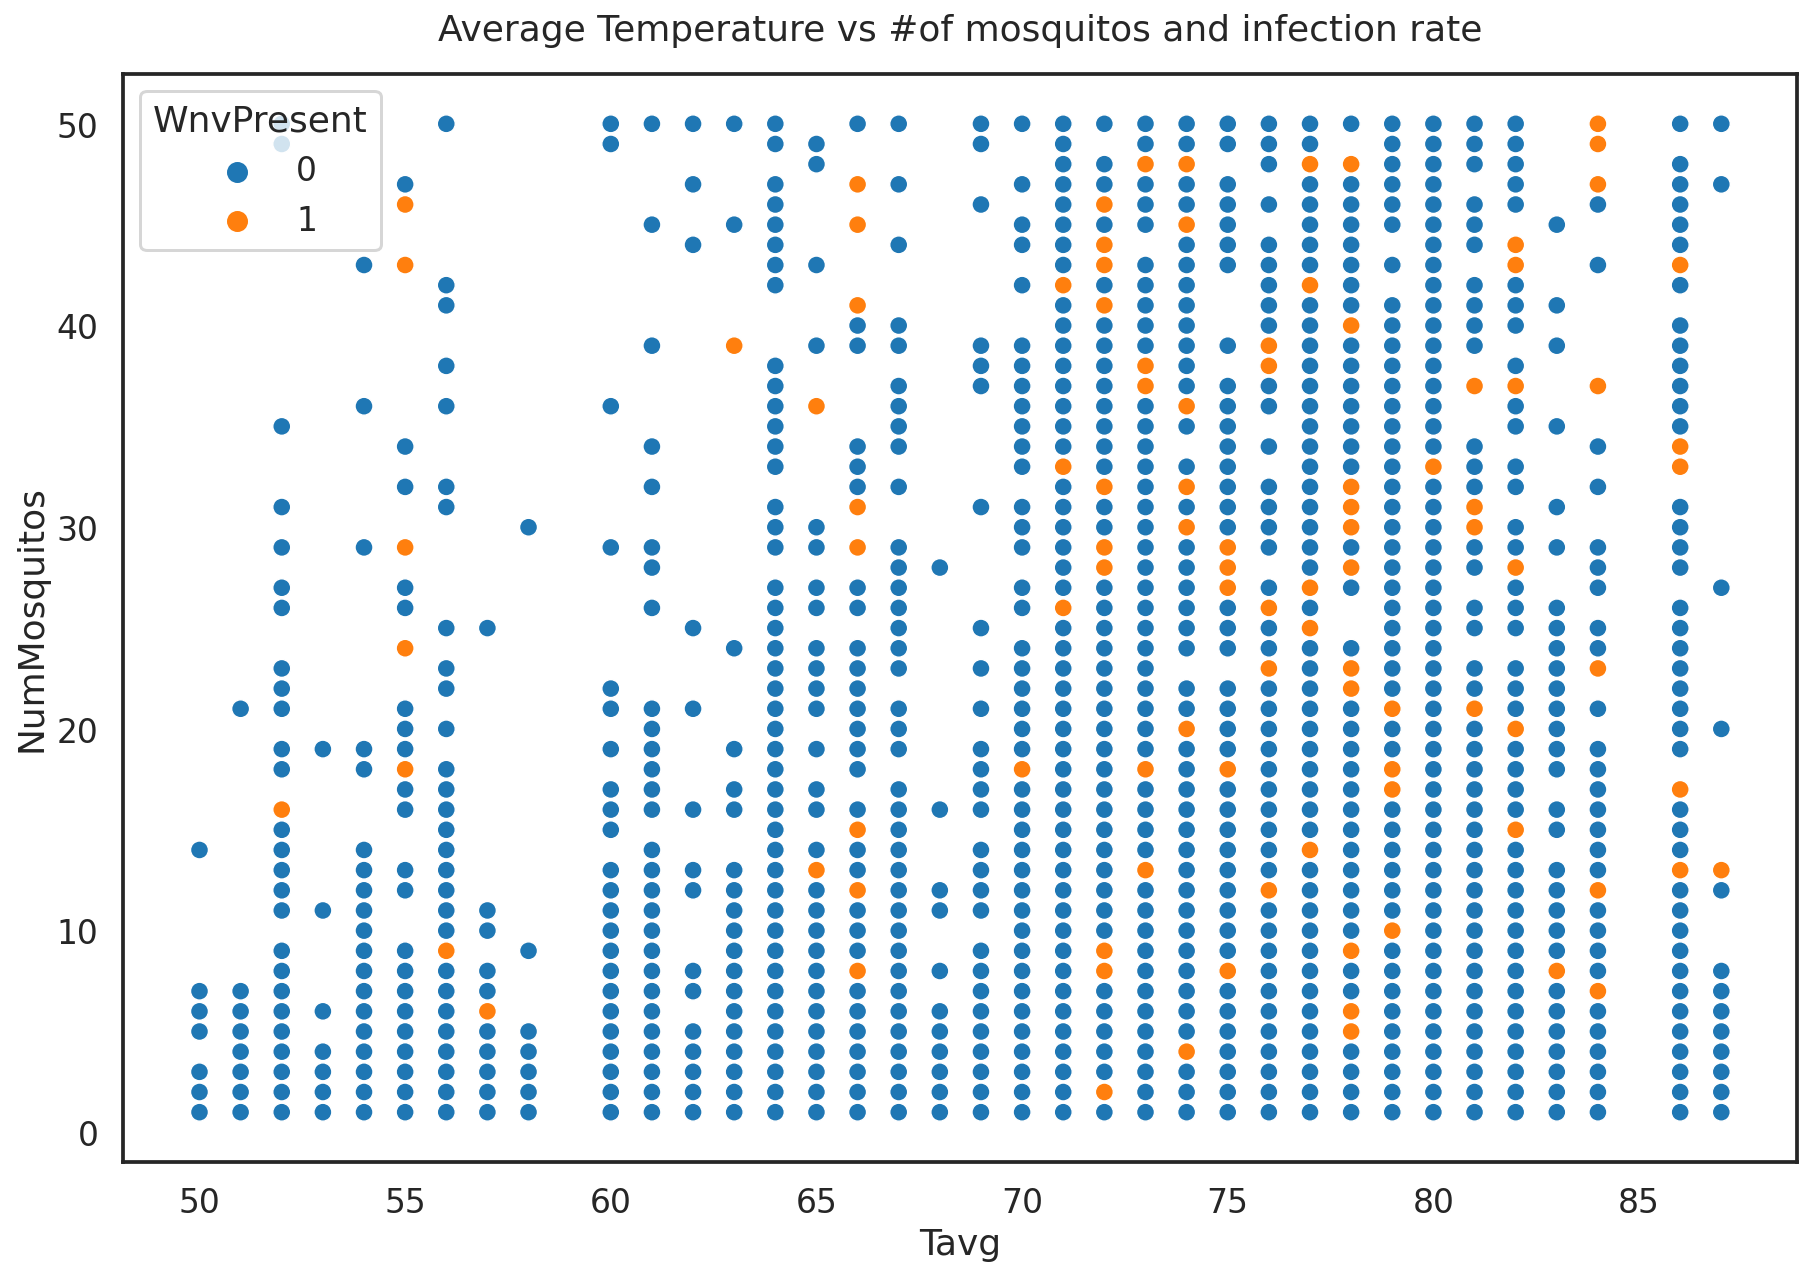

In [ ]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=df_merged.sort_values(by='Tavg'), x = 'Tavg', y = 'NumMosquitos',hue = 'WnvPresent');
plt.title('Average Temperature vs #of mosquitos and infection rate',y=1.02);

It's obvious that the higher temperature leads to higher infection rate. A threshold at 72 Farenheit clearly separted low and high WNv spread.

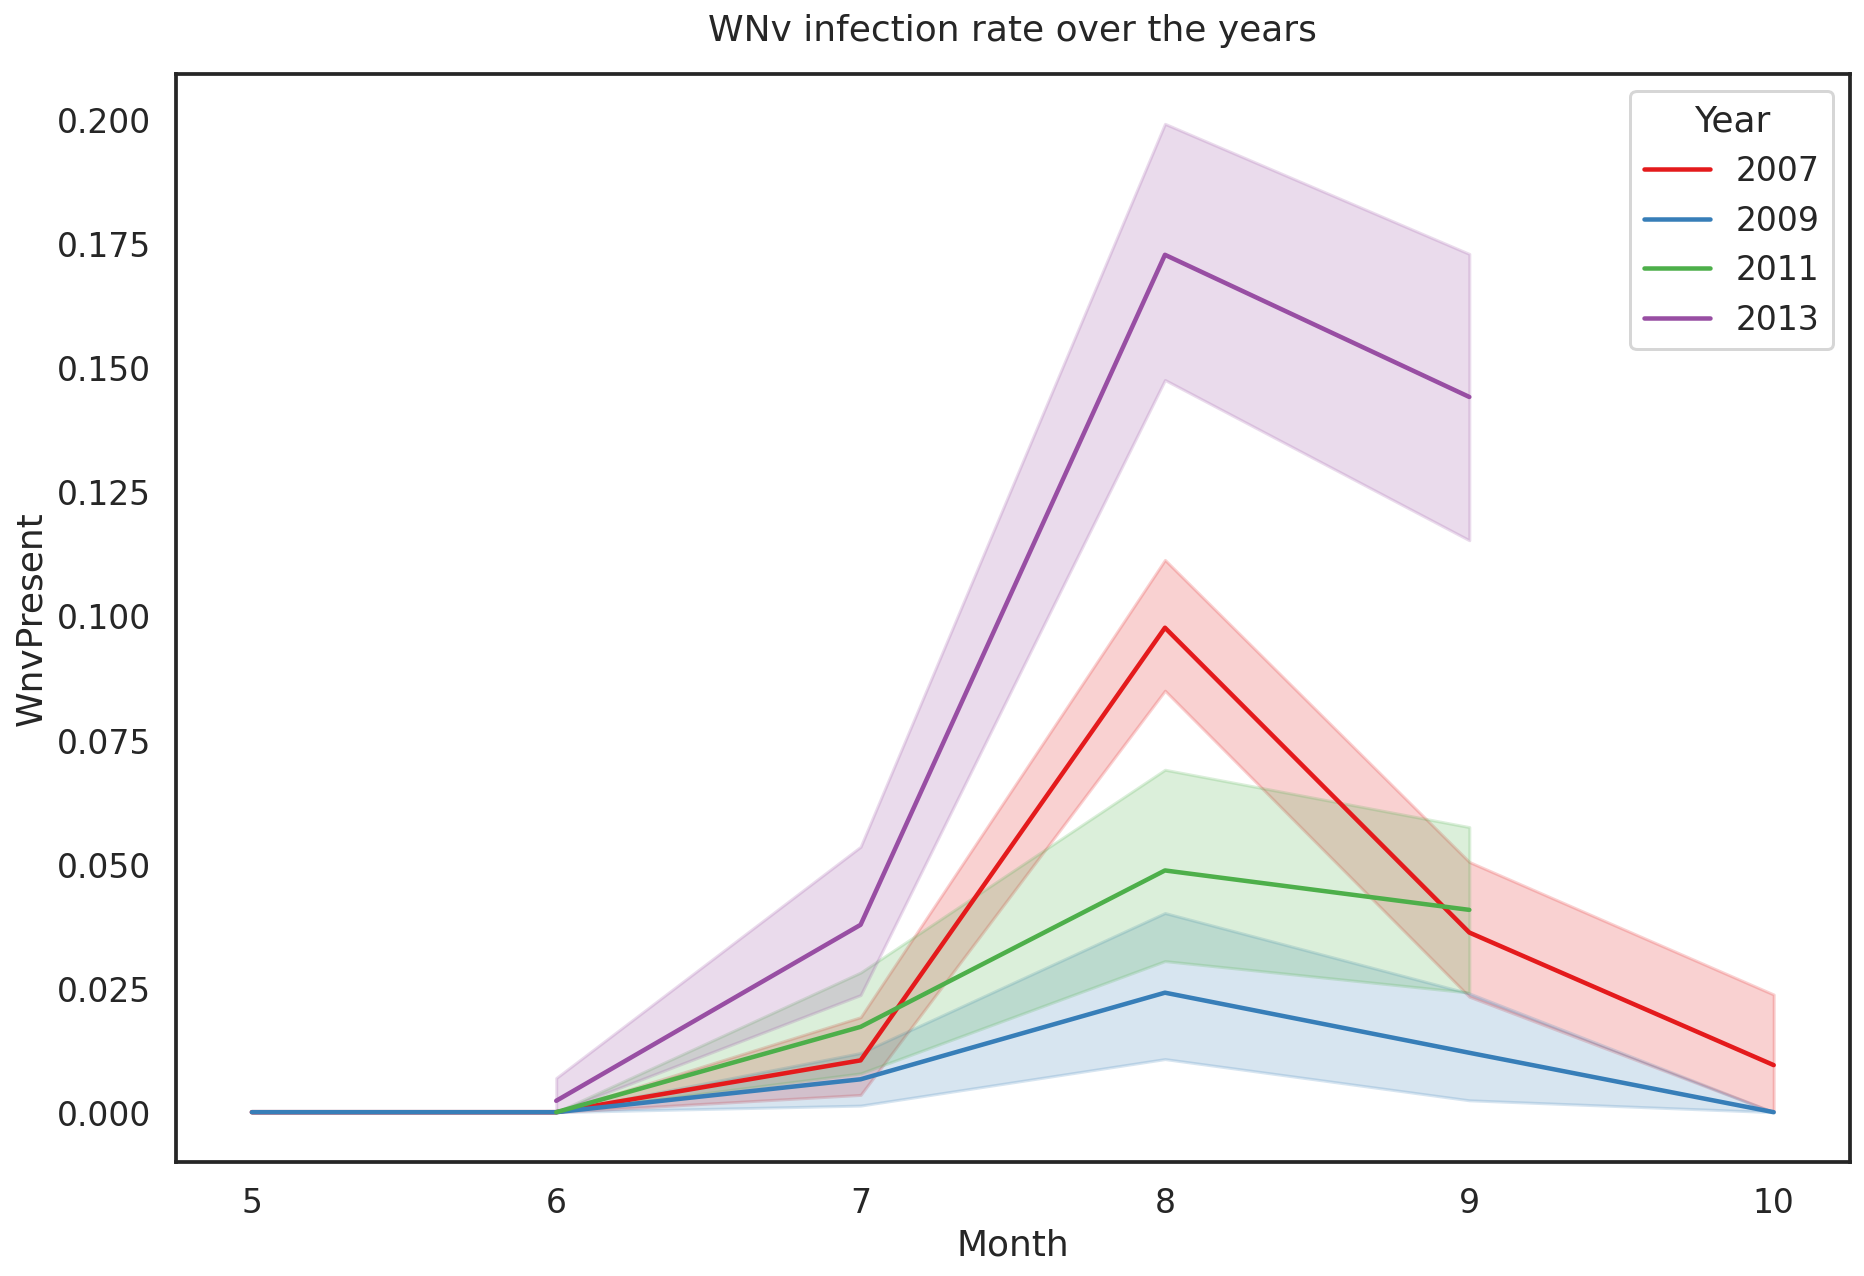

In [ ]:
plt.figure(figsize=(15,10))
sns.lineplot(data=df_merged, x = 'Month',y = 'WnvPresent', hue = 'Year',palette='Set1' )
plt.title('WNv infection rate over the years',y=1.02);

The WNv spread heavily during August of every years.

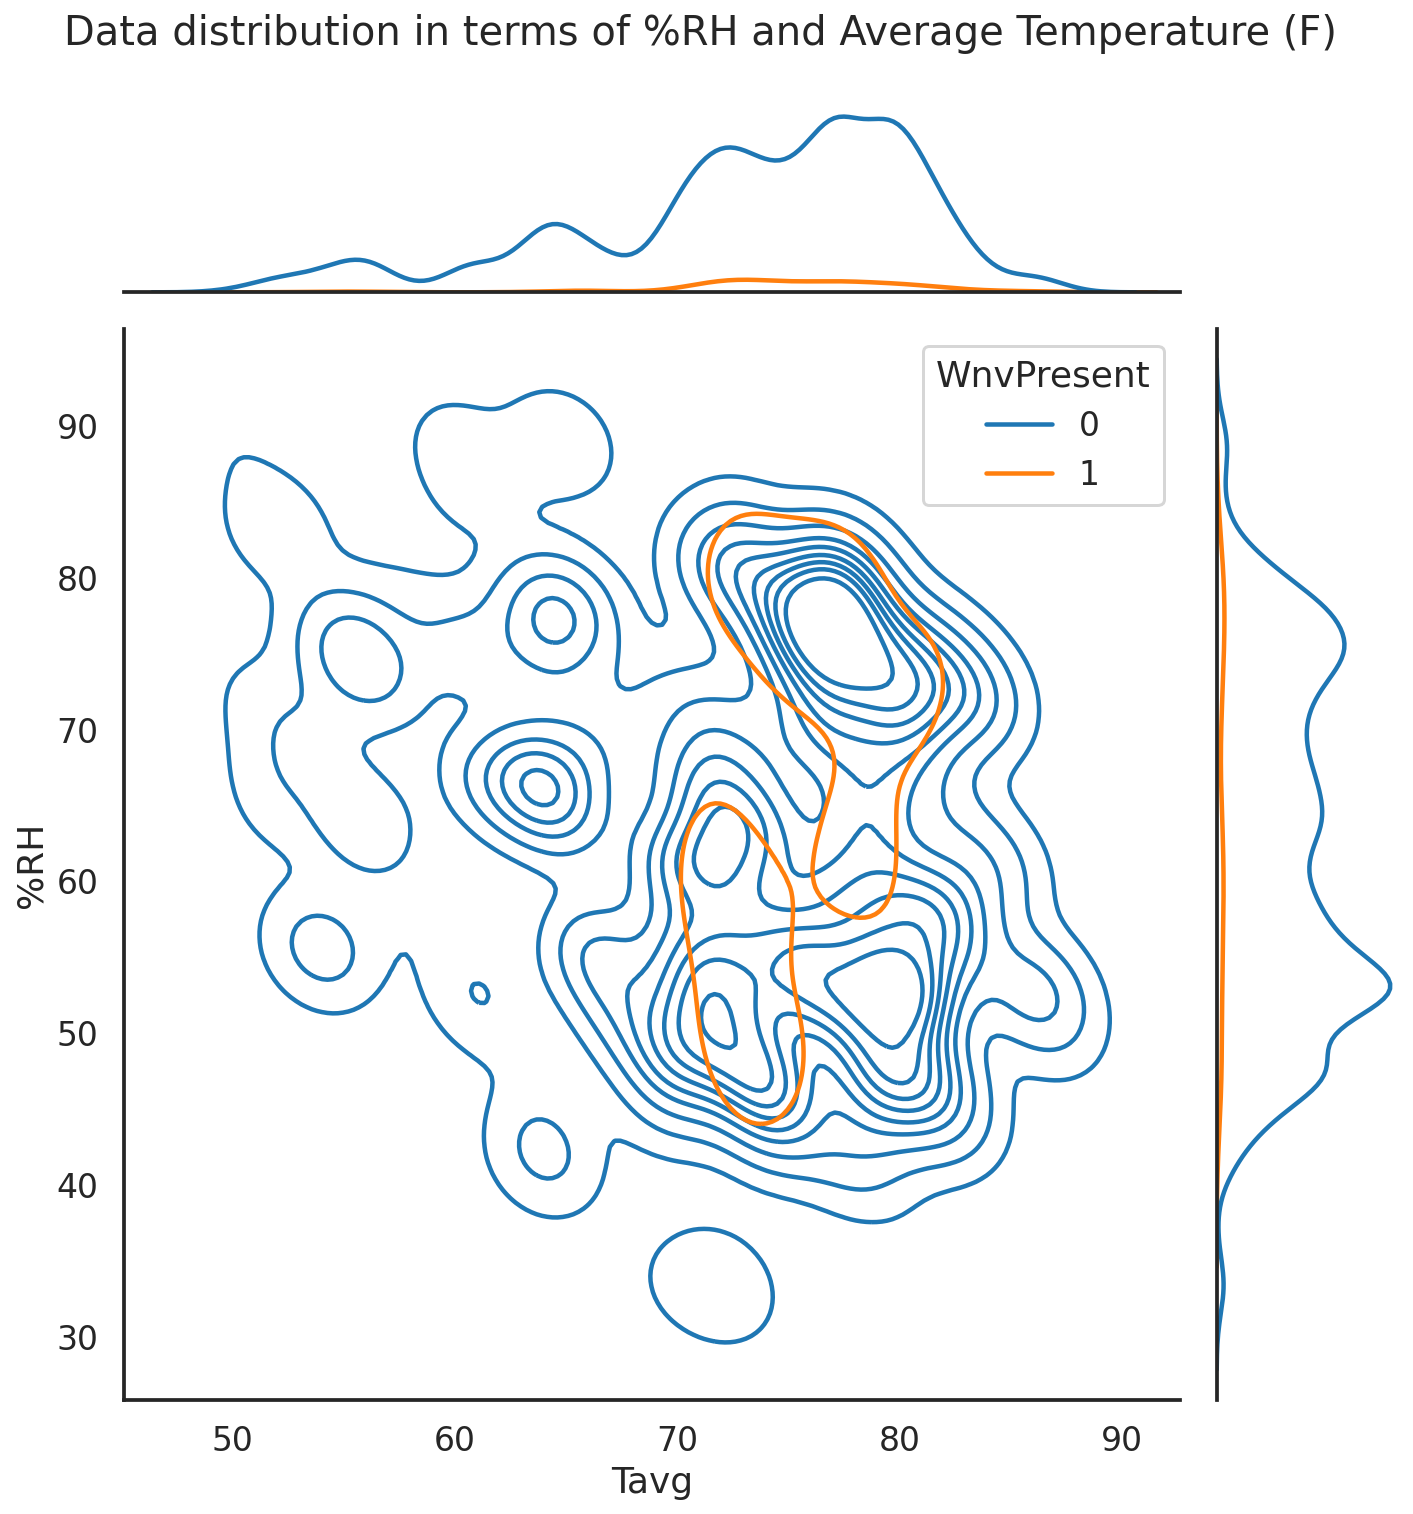

In [ ]:
# Calculating Relative Humidity (%RH)
g = sns.jointplot(data=df_merged, x="Tavg", y="%RH", hue='WnvPresent', kind = 'kde', height = 10);
g.fig.suptitle('Data distribution in terms of %RH and Average Temperature (F)',y = 1.05, fontsize = 20);

- It's clear that the WNv can spread easily in optimal range of temperature (between 70-80 degFarenheit)
- In term of relative humidity, the virus is likely to spread widely in relatively humid environment (%RH from 50% - 80%)

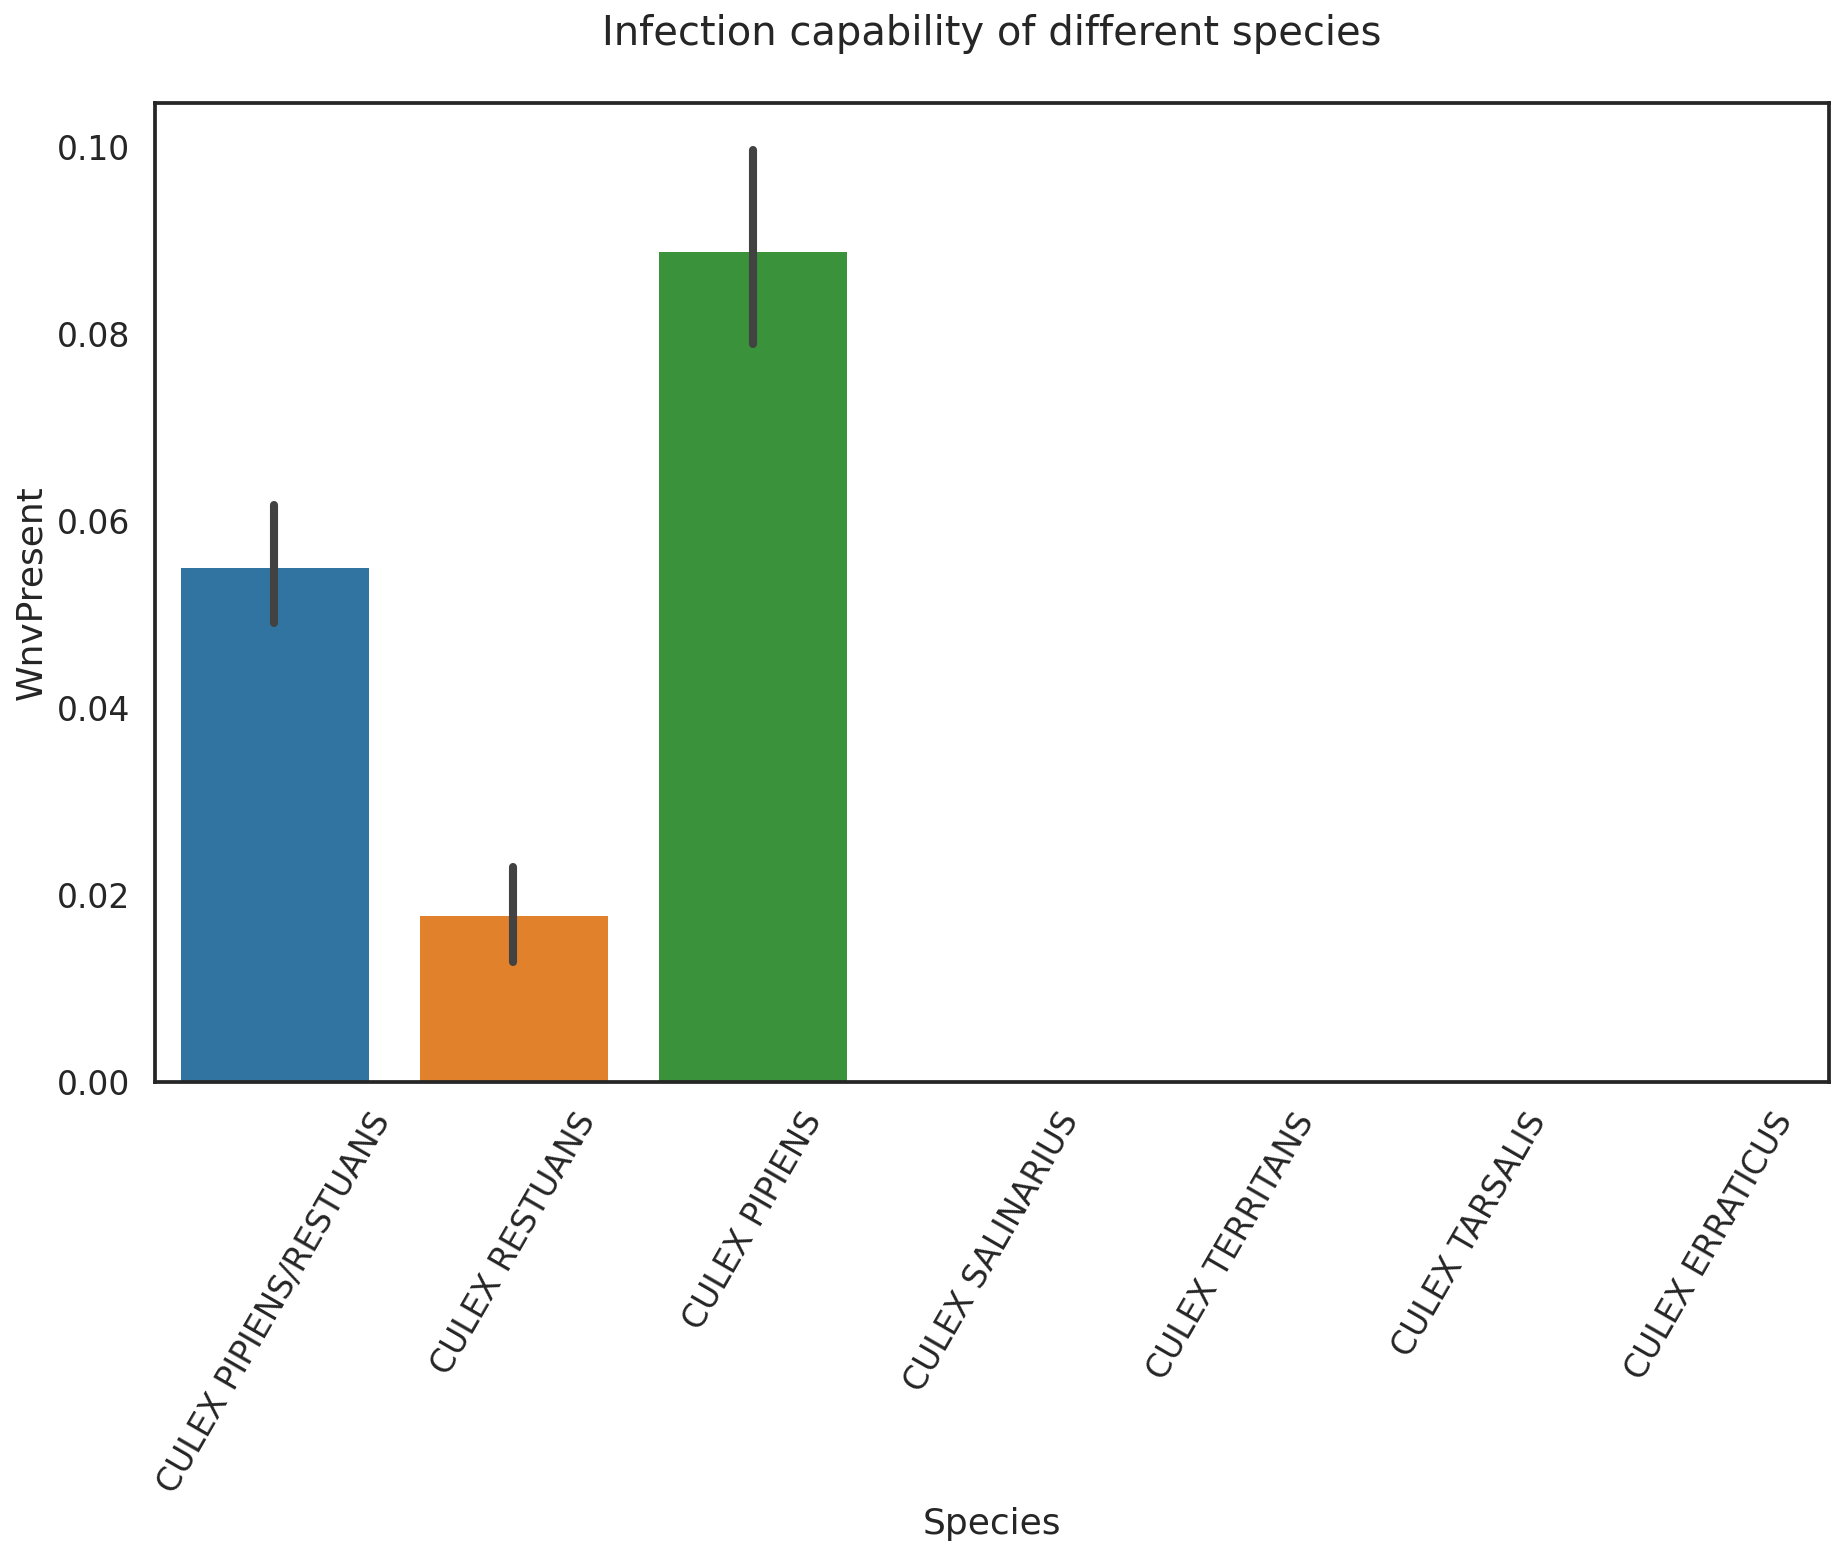

In [ ]:
plt.figure(figsize=(15,9))
g = sns.barplot(x='Species',y='WnvPresent',data=df_merged)
g.set_xticklabels(g.get_xticklabels(),rotation = 60)
plt.title('Infection capability of different species\n', fontsize=20);

Three species are the carrier of WNv, the rest have no presence of WNv infection.

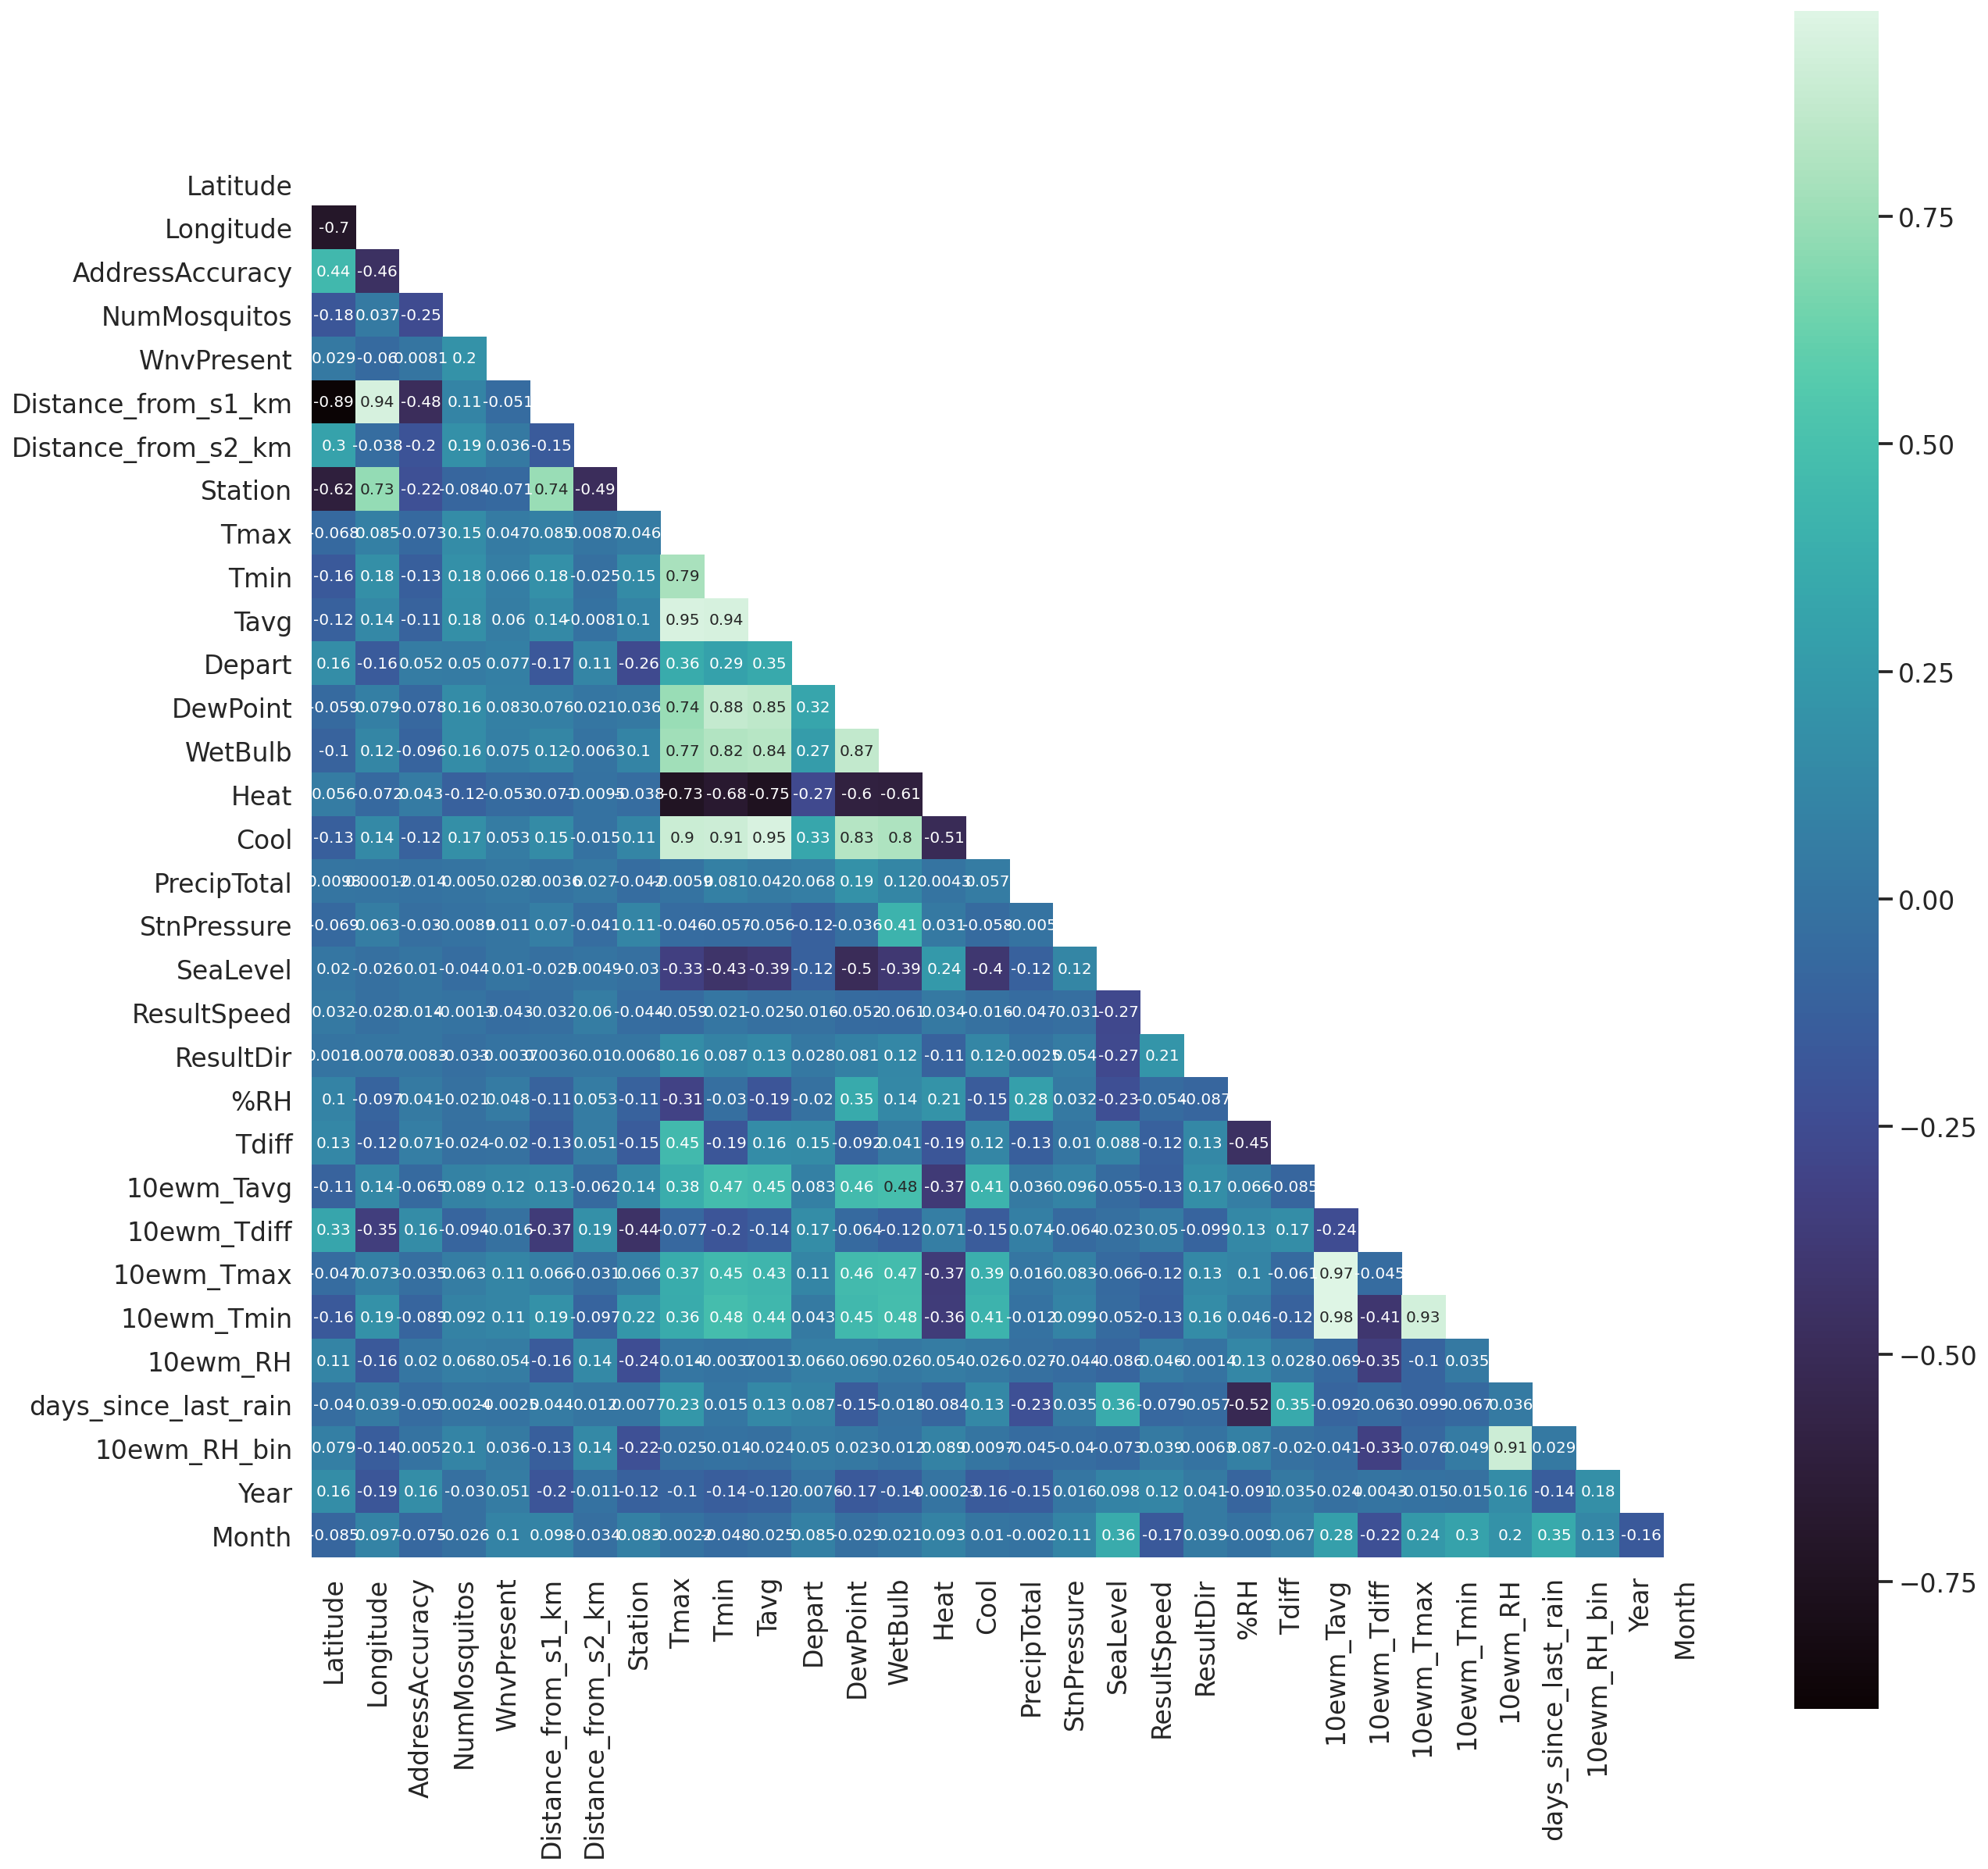

In [ ]:
corr = df_merged.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(20, 20))
ax = sns.heatmap(corr, mask=mask, square=True, annot=True, cmap = 'mako')

Overall, there is no strongest predictor for WNvPresent. However, our 10 days lagged features tend to perform better than their original (Almost double in pearson correlation)

Text(0.5, 1.0, 'Wind Speed VS Wnv spread')

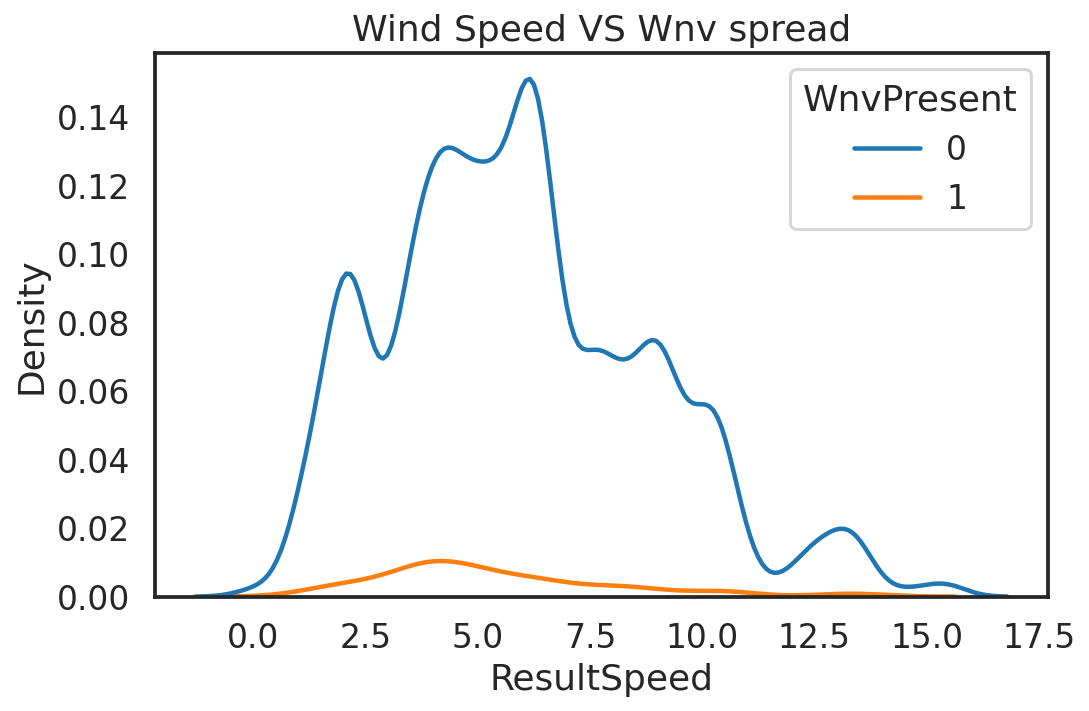

In [ ]:
plt.figure(figsize=(8,5))
g = sns.kdeplot(data=df_merged, x='ResultSpeed',hue = 'WnvPresent')
g.set_title('Wind Speed VS Wnv spread')

Moderate wind (speed between 2.5 - 7.5) is most favorble condition for the WNv.

In [ ]:
#List of significant weather condition 
weather_code = set()
for row in df_merged['CodeSum'].str.split():
#     print(set(row))
    weather_code = weather_code.union(set(row))

weather_code    

{'BR', 'DZ', 'FG', 'HZ', 'RA', 'TS', 'TSRA', 'VCTS'}

In [ ]:
#Split weather code
df_merged['CodeSum'] = df_merged['CodeSum'].str.split()

#Manuall One Hot Encoding
df_merged['metar_BR'] = df_merged['CodeSum'].map(lambda x: 1 if 'BR' in x else 0)
df_merged['metar_DZ'] = df_merged['CodeSum'].map(lambda x: 1 if 'DZ' in x else 0)
df_merged['metar_FG'] = df_merged['CodeSum'].map(lambda x: 1 if 'FG' in x else 0)
df_merged['metar_HZ'] = df_merged['CodeSum'].map(lambda x: 1 if 'HZ' in x else 0)
df_merged['metar_RA'] = df_merged['CodeSum'].map(lambda x: 1 if 'RA' in x else 0)
df_merged['metar_TS'] = df_merged['CodeSum'].map(lambda x: 1 if 'TS' in x else 0)
df_merged['metar_TSRA'] = df_merged['CodeSum'].map(lambda x: 1 if 'TSRA' in x else 0)

Text(0.5, 1.05, 'Effect of significant weather condition on the spread of WNv')

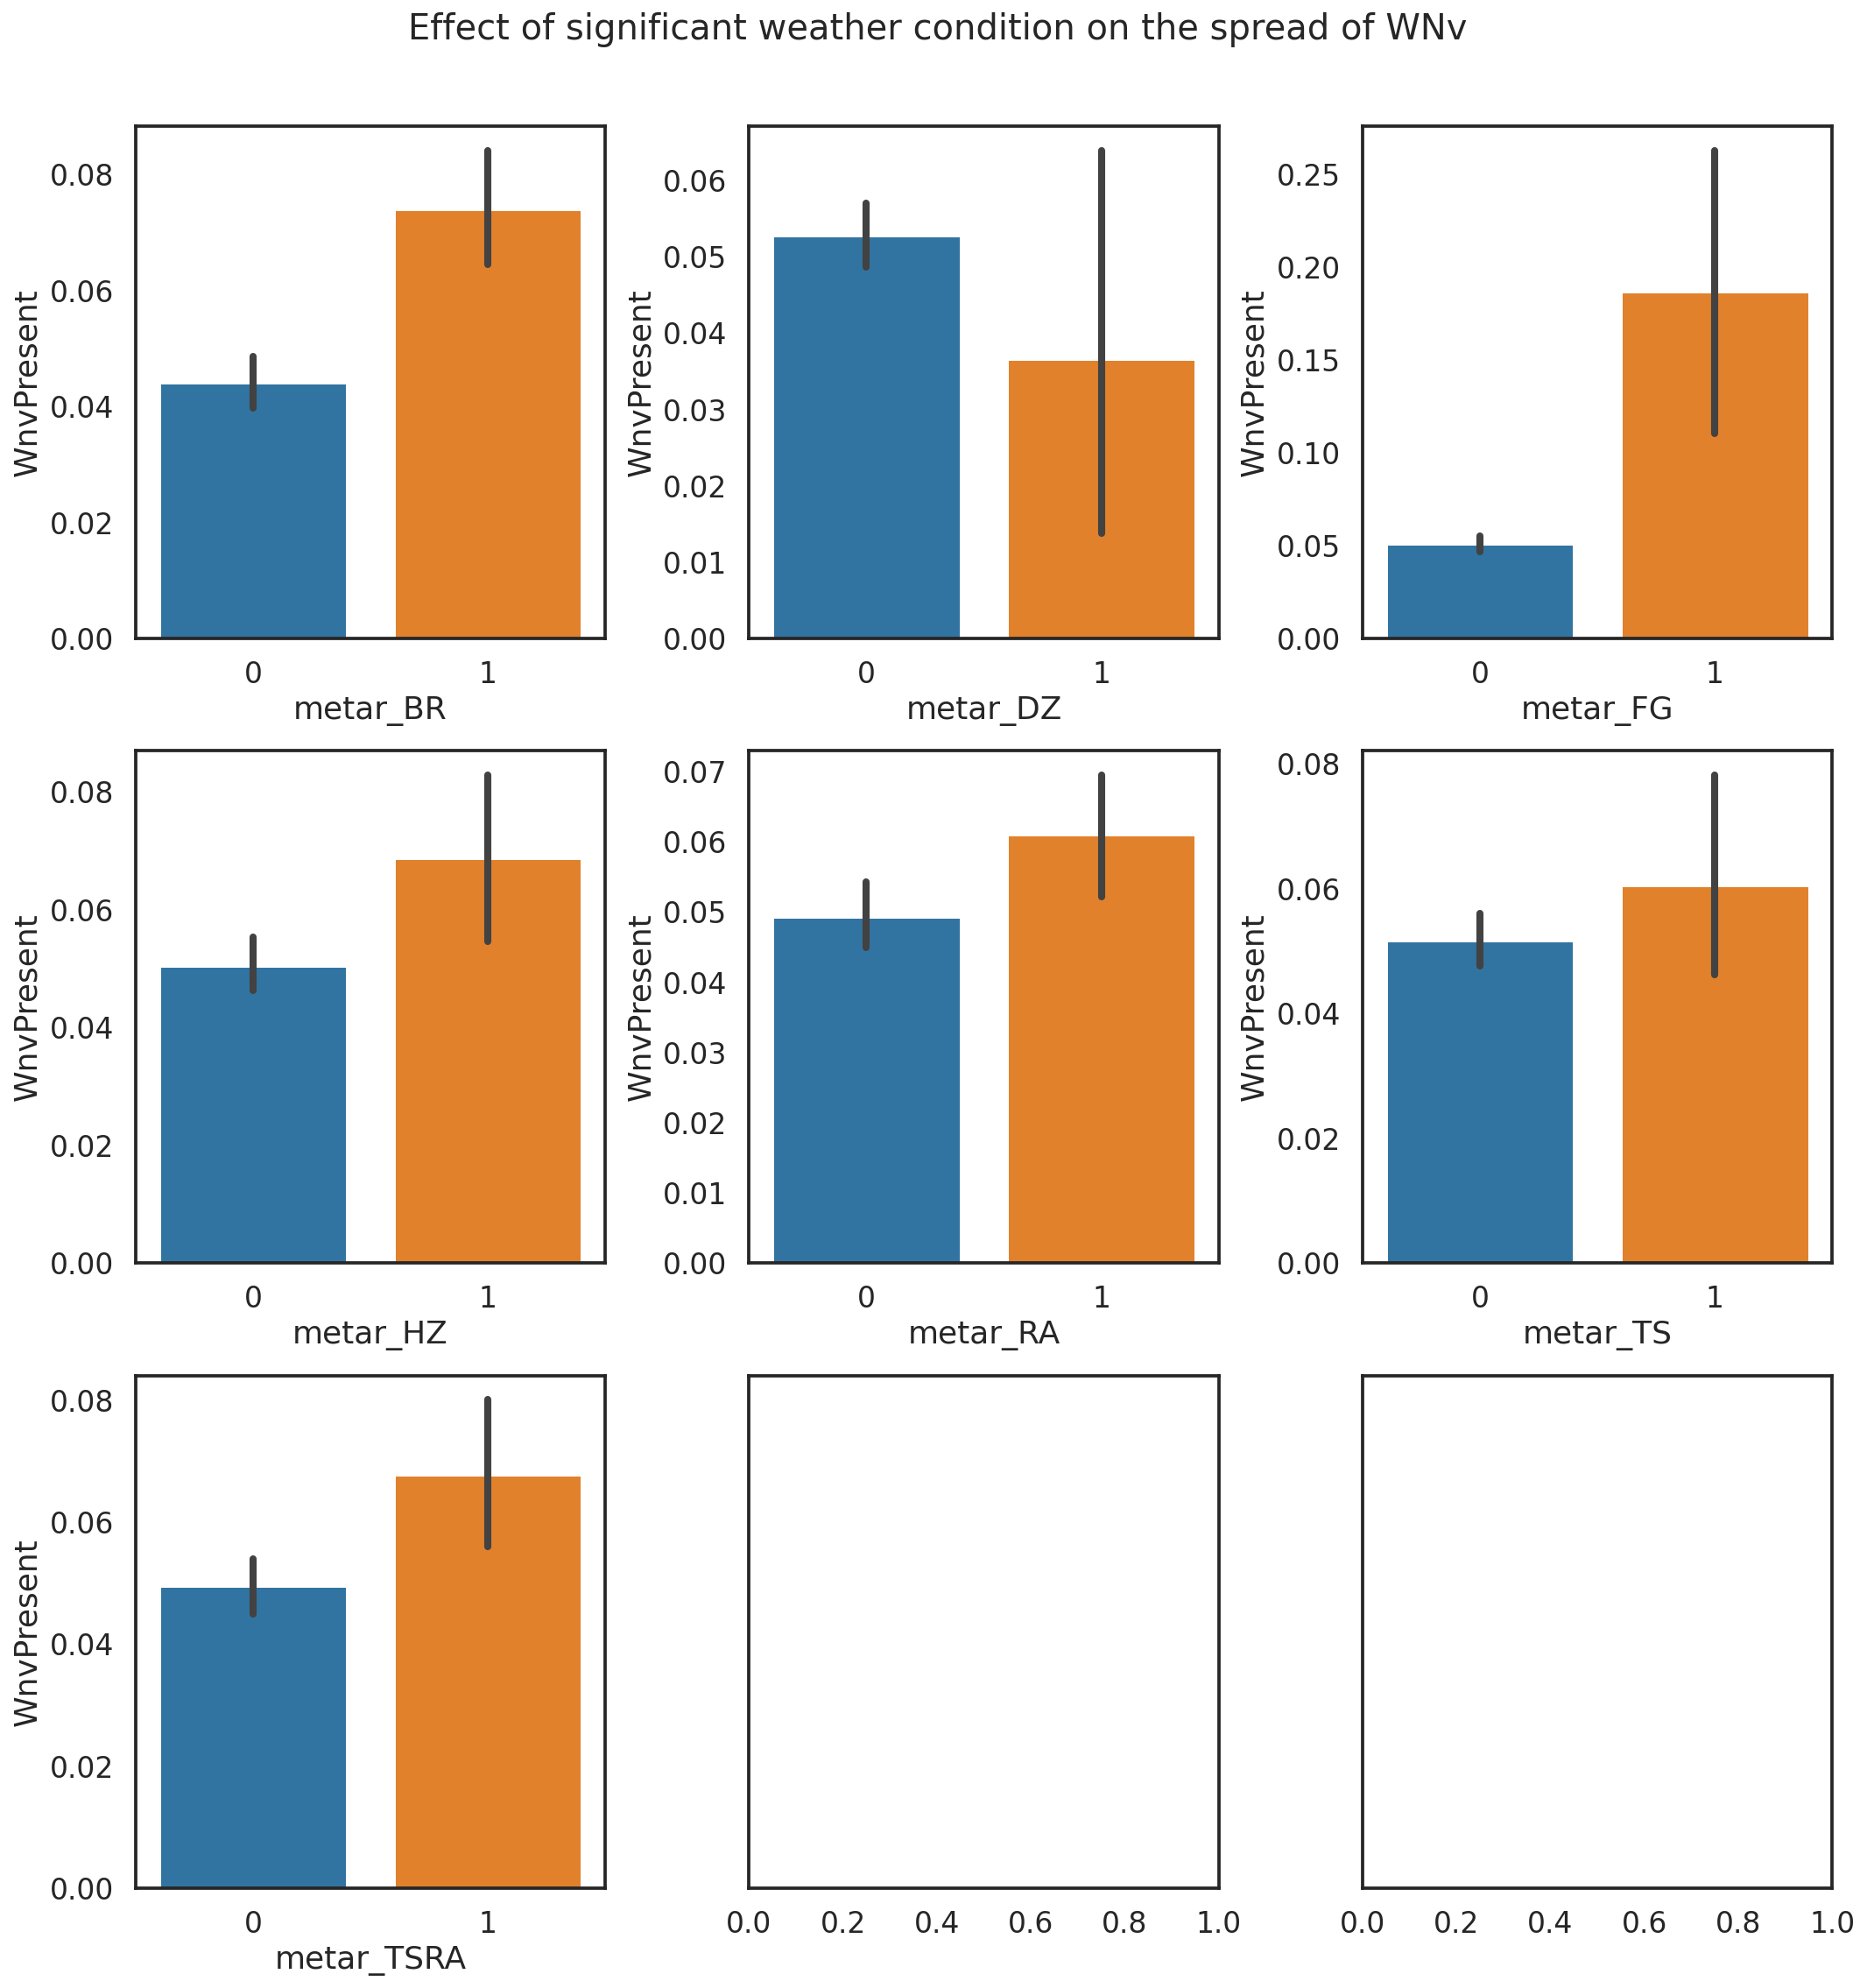

In [ ]:
plt.subplots(3,3,figsize=(15,15),sharey=True)
for i,col in enumerate(df_merged.columns[df_merged.columns.str.contains('metar')],1):
    plt.subplot(3,3,i)
    g = sns.barplot(data=df_merged,x=col,y='WnvPresent')

plt.tight_layout()
plt.suptitle('Effect of significant weather condition on the spread of WNv', y = 1.05, fontsize=20)

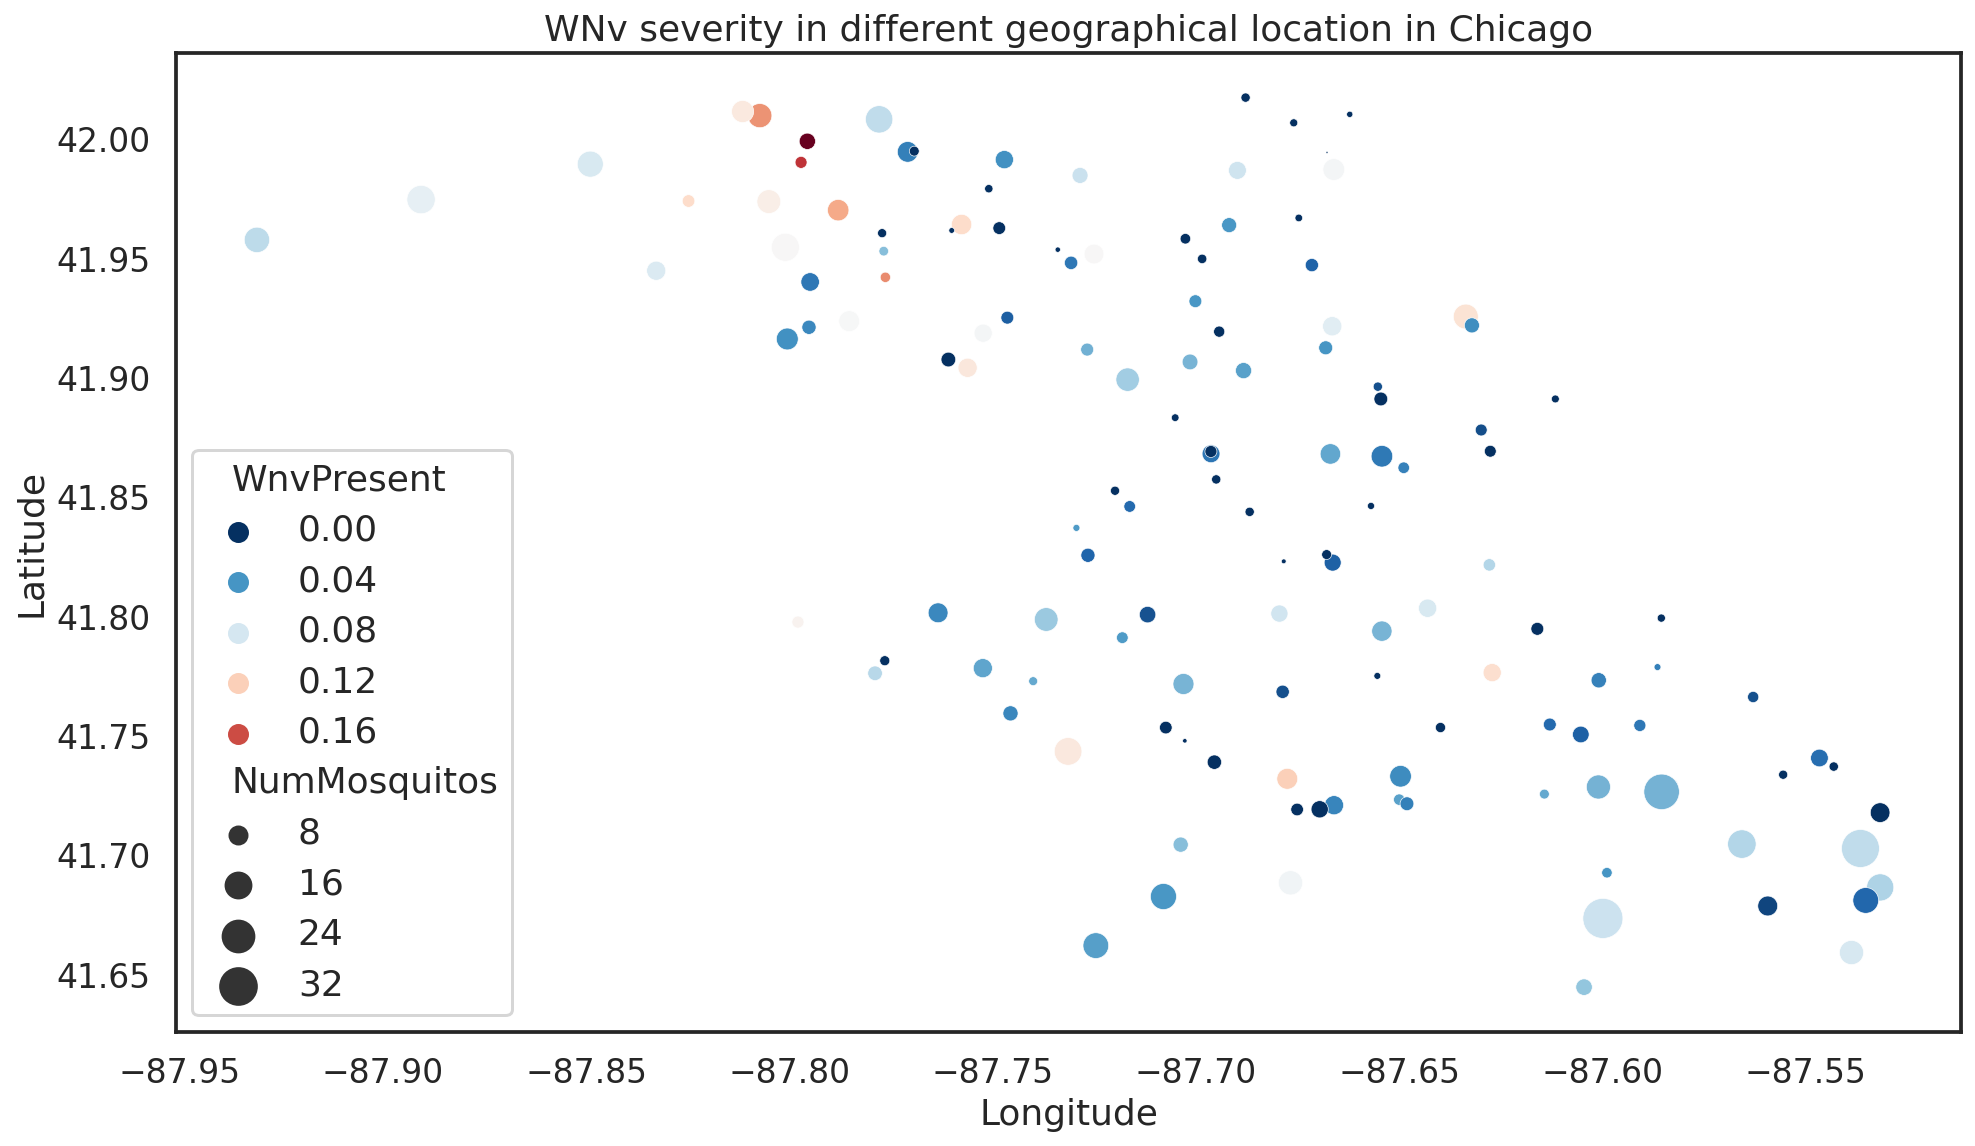

In [ ]:
#Geographical distribution of the virus
plt.figure(figsize=(16,9))
g = sns.scatterplot(data=df_merged.groupby('Trap').mean().sort_values(by='WnvPresent', ascending=False), y="Latitude", x="Longitude",
                    hue='WnvPresent', size = 'NumMosquitos' ,palette='RdBu_r', sizes = (1,400))

g.set_title('WNv severity in different geographical location in Chicago');

The Northwestern part of Chicago is the location where WNv is most widely spread.

## Data Cleaning Function

In [ ]:
def cleaning(data, weather, how='train', distance = 'empirical'):
    """
    input following information:
    data = the training / testing dataframe
    weather = weather dataframe
    spray = spraying dataframe
    how = specify whether the function will be used for {'train','test'}
    distance = specify distance calculation function {'empirical','detail'}

    """
    #Convert date into datetime object
    data['Date'] = pd.to_datetime(data['Date'])
    weather['Date'] = pd.to_datetime(weather['Date'])
    
    data = data.drop(columns=['Address', 'Block',
                              'Street', 'AddressNumberAndStreet'])
    
    if distance == 'empirical':
        
        # Distance calculation 1° = 111 km  (or 60 nautical miles)
        lat_s1 = 41.995
        long_s1 = -87.933
        lat_s2 = 41.786
        long_s2 = -87.752
    
        data['Distance_from_s1_km'] = np.sqrt(np.power(60*(data['Latitude'] - lat_s1), 2) +
                                              np.power(60*(data['Longitude'] - long_s1), 2)) * 111/60  # *111/60 to convert from NM to km
    
        data['Distance_from_s2_km'] = np.sqrt(np.power(60*(data['Latitude'] - lat_s2), 2) +
                                              np.power(60*(data['Longitude'] - long_s2), 2)) * 111/60  # *111/60 to convert from NM to km
    
        # Select dominant weather station
        data['Station'] = data.apply(lambda row: 2 if (
            row['Distance_from_s1_km'] > row['Distance_from_s2_km']) else 1, axis=1)
        
        print(data['Station'].value_counts())
        
    elif distance == 'detail':
        from math import radians, sin, cos, atan2, sqrt
        stn1_location = (41.995,-87.933)
        stn2_location = (41.786,-87.752)

        def calc_dist_chk(lat1, lon1, lat2, lon2):
            R = 6373.0     # approximate radius of earth in km
            lat1 = radians(lat1)
            lon1 = radians(lon1)
            lat2 = radians(lat2)
            lon2 = radians(lon2)
            dlon = lon2 - lon1
            dlat = lat2 - lat1
            #formula calc distance between two points 
            #haversine formula
            a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
            c = 2 * atan2(sqrt(a), sqrt(1 - a))
            #distance in km
            distance = R * c
            return round(distance, 4)
        
        def find_nearest_stn(latitude, longitude):
            dist_from_stn1 = calc_dist_chk(latitude, longitude, stn1_location[0], stn1_location[1])
            dist_from_stn2 = calc_dist_chk(latitude, longitude, stn2_location[0], stn2_location[1])
            if dist_from_stn1 <= dist_from_stn2:
                return 1
            else:
                return 2
        
        data['Station'] = 0
        for index, row in data.iterrows():
            nearest_station = find_nearest_stn(row['Latitude'],row['Longitude'])
            data.loc[index,'Station'] = nearest_station
        
        print(data['Station'].value_counts())
        
    #Merge data and weather dataframe together
    df_merged = pd.merge(data, weather, left_on=['Date','Station'],right_on=['Date','Station'])
    
    
#   "-----------------------------------------------------------------------------------------------------"
    #Type Conversion
    df_merged['Tavg'] = df_merged['Tavg'].map(lambda s: -1 if s.strip().isalpha() else int(s))
    df_merged['PrecipTotal'] = df_merged['PrecipTotal'].map(lambda s: -1 if s.strip().isalpha() else float(s))
    df_merged['WetBulb'] = df_merged['WetBulb'].map(lambda s: -1 if s.strip().isalpha() else float(s))
    df_merged['Heat'] = df_merged['Heat'].map(lambda s: -1 if s.strip().isalpha() else float(s))
    df_merged['Cool'] = df_merged['Cool'].map(lambda s: -1 if s.strip().isalpha() else float(s))
    df_merged['StnPressure'] = df_merged['StnPressure'].map(lambda s: -1 if s.strip().isalpha() else float(s))
    df_merged['SeaLevel'] = df_merged['SeaLevel'].map(lambda s: -1 if s.strip().isalpha() else float(s))
    
    #Feature Engineering
    df_merged['Month'] = df_merged['Date'].dt.month
#     df_merged['DaysOfYear'] = df_merged['Date'].dt.dayofyear
    df_merged['WeeksOfYear'] = df_merged['Date'].dt.weekofyear
    df_merged['Month'] = df_merged['Month'].astype(object)
    df_merged['Year'] = df_merged['Date'].dt.year
    df_merged['%RH'] = 100 - (25/9)*(df_merged['Tavg'] - df_merged['DewPoint'])
    df_merged['Tdiff'] = df_merged['Tmax'] - df_merged['Tmin']
    
    #Split weather code
    df_merged['CodeSum'] = df_merged['CodeSum'].str.split()
    
    #Manual One Hot Encoding
    df_merged['metar_BR'] = df_merged['CodeSum'].map(lambda x: 1 if 'BR' in x else 0)
    df_merged['metar_DZ'] = df_merged['CodeSum'].map(lambda x: 1 if 'DZ' in x else 0)
    df_merged['metar_FG'] = df_merged['CodeSum'].map(lambda x: 1 if 'FG' in x else 0)
    df_merged['metar_HZ'] = df_merged['CodeSum'].map(lambda x: 1 if 'HZ' in x else 0)
    df_merged['metar_RA'] = df_merged['CodeSum'].map(lambda x: 1 if 'RA' in x else 0)
    df_merged['metar_TS'] = df_merged['CodeSum'].map(lambda x: 1 if 'TS' in x else 0)
    df_merged['metar_TSRA'] = df_merged['CodeSum'].map(lambda x: 1 if 'TSRA' in x else 0)
    
    #Type conversion
#     df_merged['Tavg'] = df_merged['Tavg'].astype(int)
#     df_merged['PrecipTotal'] = df_merged['PrecipTotal'].map(lambda s: -1 if s.strip().isalpha() else float(s))
  
    #Subset features
    
#     all_col = [
#        'Date', 'Species', 'Trap', 'Latitude', 'Longitude', 'AddressAccuracy',
#        'NumMosquitos', 'WnvPresent', 'Distance_from_s1_km',
#        'Distance_from_s2_km', 'Station', 'Tmax', 'Tmin', 'Tavg', 'Depart',
#        'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum',
#        'Depth', 'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel',
#        'ResultSpeed', 'ResultDir', 'AvgSpeed', 'Year', 'Month', '%RH',
#        'metar_BR', 'metar_DZ', 'metar_FG', 'metar_HZ', 'metar_RA', 'metar_TS',
#        'metar_TSRA', 'month'
        
#     ]
    
    use_col = [
       'WnvPresent',
#         'Month',
        'WeeksOfYear','Species', 'Latitude', 'Longitude','Tavg','Tdiff','ResultSpeed', '%RH',       # Selected Features
        'DewPoint','WetBulb', 'Heat', 'Cool','StnPressure', 'SeaLevel','ResultDir','PrecipTotal',   # Feature to be put in PCA
        'metar_BR', 'metar_DZ', 'metar_FG', 'metar_HZ', 'metar_RA', 'metar_TS','metar_TSRA',        # Selected Features
    ]
    
    # Remove datapoint affected by spraying
    if how == 'train':
#         df_merged = df_merged[~((df_merged['Date'].dt.year == 2011) & 
#                         (df_merged['Trap'].isin(['T006', 'T014', 'T015', 'T223'])))]
        
#         df_merged = df_merged[~((df_merged['Date'].dt.year == 2013) & 
#                         (df_merged['Trap'].isin(
#                                                 """T016
#                                                 T223
#                                                 T143
#                                                 T008
#                                                 T028
#                                                 T231
#                                                 T001
#                                                 T218
#                                                 T228
#                                                 T147
#                                                 T050
#                                                 T017
#                                                 T142
#                                                 T144
#                                                 T013
#                                                 T037
#                                                 T151
#                                                 T153
#                                                 T230
#                                                 T044
#                                                 T066
#                                                 T156
#                                                 T159
#                                                 T089
#                                                 T085
#                                                 T080
#                                                 T162
#                                                 T227""".split())))]
        return df_merged[use_col]
    
    # if data is the test set, return without chopping out effect of spray 
    elif how == 'test':
        return df_merged[use_col[1:]]

In [ ]:
def cleaning2(data, weather, how='train', distance='empirical'):
    """
    input following information:
    data = the training / testing dataframe
    weather = weather dataframe
    spray = spraying dataframe
    how = specify whether the function will be used for {'train','test'}
    distance = specify distance calculation function {'empirical','detail'}

    """
    # Convert date into datetime object
    data['Date'] = pd.to_datetime(data['Date'])

    # Preprocessing Weather Data (Type conversion)
    weather['Date'] = pd.to_datetime(weather['Date'])
    weather['PrecipTotal'] = weather['PrecipTotal'].map(
        lambda s: -1 if s.strip().isalpha() else float(s))
    weather['WetBulb'] = weather['WetBulb'].map(
        lambda s: -1 if s.strip().isalpha() else float(s))
    weather['Heat'] = weather['Heat'].map(
        lambda s: -1 if s.strip().isalpha() else float(s))
    weather['Cool'] = weather['Cool'].map(
        lambda s: -1 if s.strip().isalpha() else float(s))
    weather['StnPressure'] = weather['StnPressure'].map(
        lambda s: -1 if s.strip().isalpha() else float(s))
    weather['SeaLevel'] = weather['SeaLevel'].map(
        lambda s: -1 if s.strip().isalpha() else float(s))
    weather['Tavg'] = weather['Tavg'].map(
        lambda s: -1 if s.strip().isalpha() else float(s))
    weather['Depart'] = weather['Depart'].map(
        lambda s: 0 if s.strip().isalpha() else float(s))

    # Feature engineering
    weather['%RH'] = 100 - (25/9)*(weather['Tavg'] - weather['DewPoint'])
    weather['Tdiff'] = weather['Tmax'] - weather['Tmin']

    # Separately clean each weather station
    weather_1 = weather[weather['Station'] == 1].set_index('Date')
    weather_2 = weather[weather['Station'] == 2].set_index('Date')

    for weat in [weather_1, weather_2]:
        # Calculating number of days since last rain
        days_since_last_rain = []
        count = 0
        for rain in weat['PrecipTotal']:
            if rain <= 0:
                count += 1
                days_since_last_rain.append(count)
            if rain > 0:
                count = 0
                days_since_last_rain.append(count)

        days_since_last_rain = pd.Series(
            days_since_last_rain, index=weat.index, name='days_since_last_rain')

        # 10 days shifting + exponential weighted mean
        d10ewm_Tavg = weat.Tavg.shift(10).resample(
            'D').mean().ewm(span=10).mean().rename('10ewm_Tavg')
        d10ewm_Tdiff = weat.Tdiff.shift(10).resample(
            'D').mean().ewm(span=10).mean().rename('10ewm_Tdiff')
        d10ewm_Tmax = weat.Tmax.shift(10).resample(
            'D').mean().ewm(span=10).mean().rename('10ewm_Tmax')
        d10ewm_Tmin = weat.Tmin.shift(10).resample(
            'D').mean().ewm(span=10).mean().rename('10ewm_Tmin')
        d10ewm_DewPoint = weat.DewPoint.shift(10).resample(
            'D').mean().ewm(span=10).mean().rename('10ewm_DewPoint')
        d10ewm_WetBulb = weat.WetBulb.shift(10).resample(
            'D').mean().ewm(span=10).mean().rename('10ewm_WetBulb')
        d10ewm_RH = weat['%RH'].shift(10).resample(
            'D').mean().ewm(span=10).mean().rename('10ewm_RH')
        
        # Add additional features do the weather information
        weat = pd.concat([weat, d10ewm_Tavg, d10ewm_Tdiff, d10ewm_Tmax,
                          d10ewm_Tmin, d10ewm_DewPoint, d10ewm_WetBulb, d10ewm_RH, days_since_last_rain], axis=1)
        weat = weat.dropna(subset=['Station'])
        weat['10ewm_Tavg'] = weat['10ewm_Tavg'].fillna(weat['Tavg'])
        weat['10ewm_Tdiff'] = weat['10ewm_Tdiff'].fillna(weat['Tdiff'])
        weat['10ewm_Tmax'] = weat['10ewm_Tmax'].fillna(weat['Tmax'])
        weat['10ewm_Tmin'] = weat['10ewm_Tmin'].fillna(weat['Tmin'])
        weat['10ewm_DewPoint'] = weat['10ewm_DewPoint'].fillna(weat['DewPoint'])
        weat['10ewm_WetBulb'] = weat['10ewm_WetBulb'].fillna(weat['WetBulb'])
        weat['10ewm_RH'] = weat['10ewm_RH'].fillna(weat['%RH'])
        #Binning 10erw_rh
        def bin_rh(row):
            if row < 50:
                return 1
            elif row < 60:
                return 2
            elif row < 70:
                return 3
            else:
                return 4
        
        weat['10ewm_RH_bin'] = weat['10ewm_RH'].map(bin_rh)
        
        def bin_ws(row):
            if row < 2.5:
                return 1
            elif row < 5:
                return 2
            elif row < 7.5:
                return 3
            elif row < 10:
                return 4
            else:
                return 5
        weat['WindSpeed_bin'] = weat['ResultSpeed'].map(bin_ws)
        
        if weat.Station.unique() == 1:
            weather_1 = weat
        else:
            weather_2 = weat
    
    # Remerge weather data into a single dataframe

    weather = pd.concat([weather_1,weather_2])

    data = data.drop(columns=['Address', 'Block',
                              'Street', 'AddressNumberAndStreet'])
    
    # Select distance calculation function

    if distance == 'empirical':

        # Distance calculation 1° = 111 km  (or 60 nautical miles)
        lat_s1 = 41.995
        long_s1 = -87.933
        lat_s2 = 41.786
        long_s2 = -87.752

        data['Distance_from_s1_km'] = np.sqrt(np.power(60*(data['Latitude'] - lat_s1), 2) +
                                              np.power(60*(data['Longitude'] - long_s1), 2)) * 111/60  # *111/60 to convert from NM to km

        data['Distance_from_s2_km'] = np.sqrt(np.power(60*(data['Latitude'] - lat_s2), 2) +
                                              np.power(60*(data['Longitude'] - long_s2), 2)) * 111/60  # *111/60 to convert from NM to km

        # Select dominant weather station
        data['Station'] = data.apply(lambda row: 2 if (
            row['Distance_from_s1_km'] > row['Distance_from_s2_km']) else 1, axis=1)

        print(data['Station'].value_counts())

    elif distance == 'detail':
        from math import radians, sin, cos, atan2, sqrt
        stn1_location = (41.995, -87.933)
        stn2_location = (41.786, -87.752)

        def calc_dist_chk(lat1, lon1, lat2, lon2):
            R = 6373.0     # approximate radius of earth in km
            lat1 = radians(lat1)
            lon1 = radians(lon1)
            lat2 = radians(lat2)
            lon2 = radians(lon2)
            dlon = lon2 - lon1
            dlat = lat2 - lat1
            # formula calc distance between two points
            # haversine formula
            a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
            c = 2 * atan2(sqrt(a), sqrt(1 - a))
            #distance in km
            distance = R * c
            return round(distance, 4)

        def find_nearest_stn(latitude, longitude):
            dist_from_stn1 = calc_dist_chk(
                latitude, longitude, stn1_location[0], stn1_location[1])
            dist_from_stn2 = calc_dist_chk(
                latitude, longitude, stn2_location[0], stn2_location[1])
            if dist_from_stn1 <= dist_from_stn2:
                return 1
            else:
                return 2

        data['Station'] = 0
        for index, row in data.iterrows():
            nearest_station = find_nearest_stn(
                row['Latitude'], row['Longitude'])
            data.loc[index, 'Station'] = nearest_station

        print(data['Station'].value_counts())

    # Merge data and weather dataframe together
    df_merged = pd.merge(data, weather, left_on=[
                         'Date', 'Station'], right_on=['Date', 'Station'])


#   "-----------------------------------------------------------------------------------------------------"

    # Feature Engineering
    df_merged['Month'] = df_merged['Date'].dt.month
    df_merged['Month'] = df_merged['Month'].astype(object)
#     df_merged['DaysOfYear'] = df_merged['Date'].dt.dayofyear
    df_merged['WeeksOfYear'] = df_merged['Date'].dt.weekofyear
#     df_merged['Year'] = df_merged['Date'].dt.year

    # Split weather code
    df_merged['CodeSum'] = df_merged['CodeSum'].str.split()

    # Manual One Hot Encoding
    df_merged['metar_BR'] = df_merged['CodeSum'].map(
        lambda x: 1 if 'BR' in x else 0)
    df_merged['metar_DZ'] = df_merged['CodeSum'].map(
        lambda x: 1 if 'DZ' in x else 0)
    df_merged['metar_FG'] = df_merged['CodeSum'].map(
        lambda x: 1 if 'FG' in x else 0)
    df_merged['metar_HZ'] = df_merged['CodeSum'].map(
        lambda x: 1 if 'HZ' in x else 0)
    df_merged['metar_RA'] = df_merged['CodeSum'].map(
        lambda x: 1 if 'RA' in x else 0)
    df_merged['metar_TS'] = df_merged['CodeSum'].map(
        lambda x: 1 if 'TS' in x else 0)
    df_merged['metar_TSRA'] = df_merged['CodeSum'].map(
        lambda x: 1 if 'TSRA' in x else 0)


    # Subset features
#     all_col = ['Date', 'Species', 'Trap', 'Latitude', 'Longitude', 'AddressAccuracy',
#        'NumMosquitos', 'WnvPresent', 'Distance_from_s1_km',
#        'Distance_from_s2_km', 'Station', 'Tmax', 'Tmin', 'Tavg', 'Depart',
#        'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum',
#        'Depth', 'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel',
#        'ResultSpeed', 'ResultDir', 'AvgSpeed', '%RH', 'Tdiff', '10ewm_Tavg',
#        '10ewm_Tdiff', '10ewm_Tmax', '10ewm_Tmin', '10ewm_RH',
#        'days_since_last_rain', '10ewm_RH_bin', 'Year', 'Month']


    use_col = [
        'WnvPresent',
                'Month','Trap',
        # Selected Features
        'WeeksOfYear', 'Species', 'Latitude', 'Longitude', 'Tavg', 'Tdiff','Tmax', 'Tmin','DewPoint', 'WetBulb', 'ResultSpeed','WindSpeed_bin', '%RH',
        # lagged features
        '10ewm_Tavg','10ewm_Tdiff', '10ewm_Tmax', '10ewm_Tmin','10ewm_DewPoint','10ewm_WetBulb','days_since_last_rain', '10ewm_RH_bin',
        # Selected Features
        'metar_BR', 'metar_DZ', 'metar_FG', 'metar_HZ', 'metar_RA', 'metar_TS', 'metar_TSRA',
    ]

    #Included 'WNvPresent' in the training set
    if how == 'train':
        return df_merged[use_col]

    # if data is the test set, skip the 'WNvPresent' columns
    elif how == 'test':
        return df_merged[use_col[1:]]

# Preprocessing

In [ ]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
weather = pd.read_csv('/content/weather.csv')

In [ ]:
#Data Cleaning
df_train = cleaning2(train, weather, how='train', distance = 'detail')
weather = pd.read_csv('/content/weather.csv')
df_test = cleaning2(test, weather, how='test', distance = 'detail')

X = df_train.drop(columns='WnvPresent')
y = df_train['WnvPresent']
X_test = df_test

2    7208
1    3298
Name: Station, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


2    80892
1    35401
Name: Station, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


## Clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

scores = []
for k in range(2, 15):
    cluster = KMeans(n_clusters=k,random_state=42)
    cluster.fit(X[['Latitude','Longitude']])
    inertia = cluster.inertia_
    sil_score = silhouette_score(X[['Latitude','Longitude']], cluster.labels_)

    scores.append([k, inertia, sil_score])
    
scores_df = pd.DataFrame(scores,columns = ['n_clusters','inertia','silhouette'])

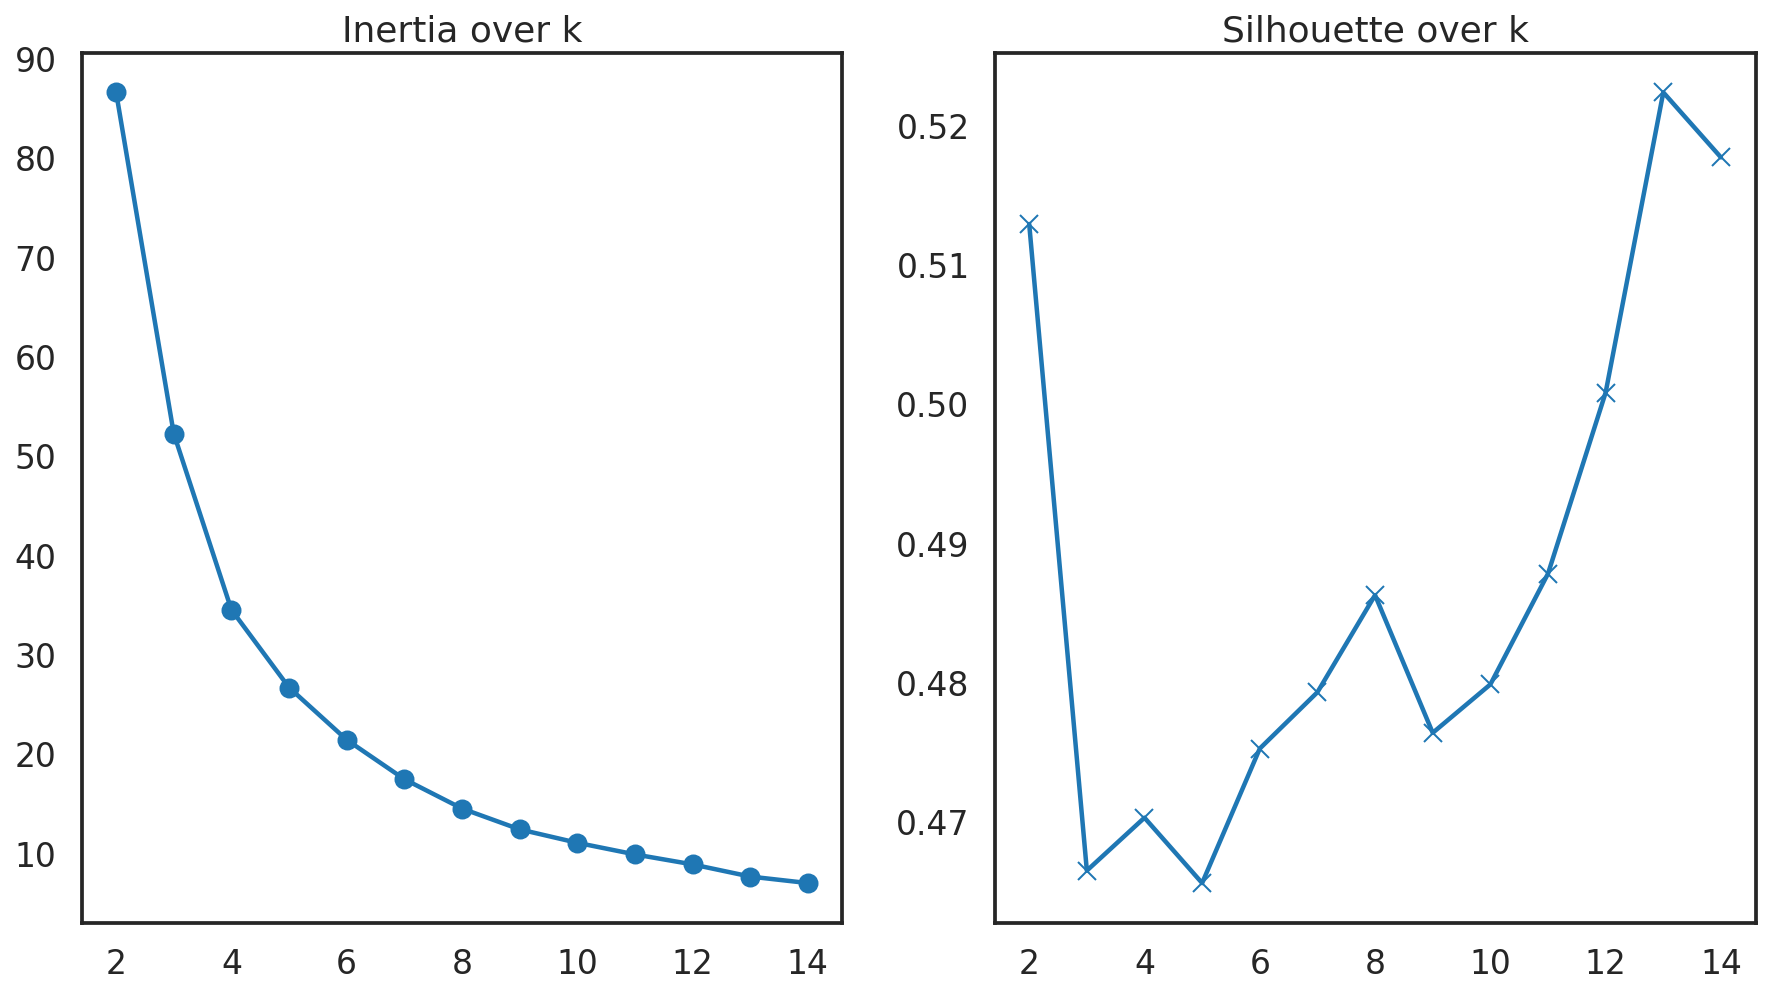

In [ ]:
fig, axes = plt.subplots(1,2, figsize = (15,8))

axes[0].plot(scores_df.n_clusters,scores_df.inertia, marker = 'o')
axes[0].set_title('Inertia over k')

axes[1].plot(scores_df.n_clusters,scores_df.silhouette, marker = 'x')
axes[1].set_title('Silhouette over k');

In [ ]:
cluster = KMeans(n_clusters=6,random_state=42)
cluster.fit(X[['Latitude','Longitude']])

#Clustering 
X['Cluster'] = cluster.predict(X[['Latitude','Longitude']])
X_test['Cluster'] = cluster.predict(X_test[['Latitude','Longitude']])

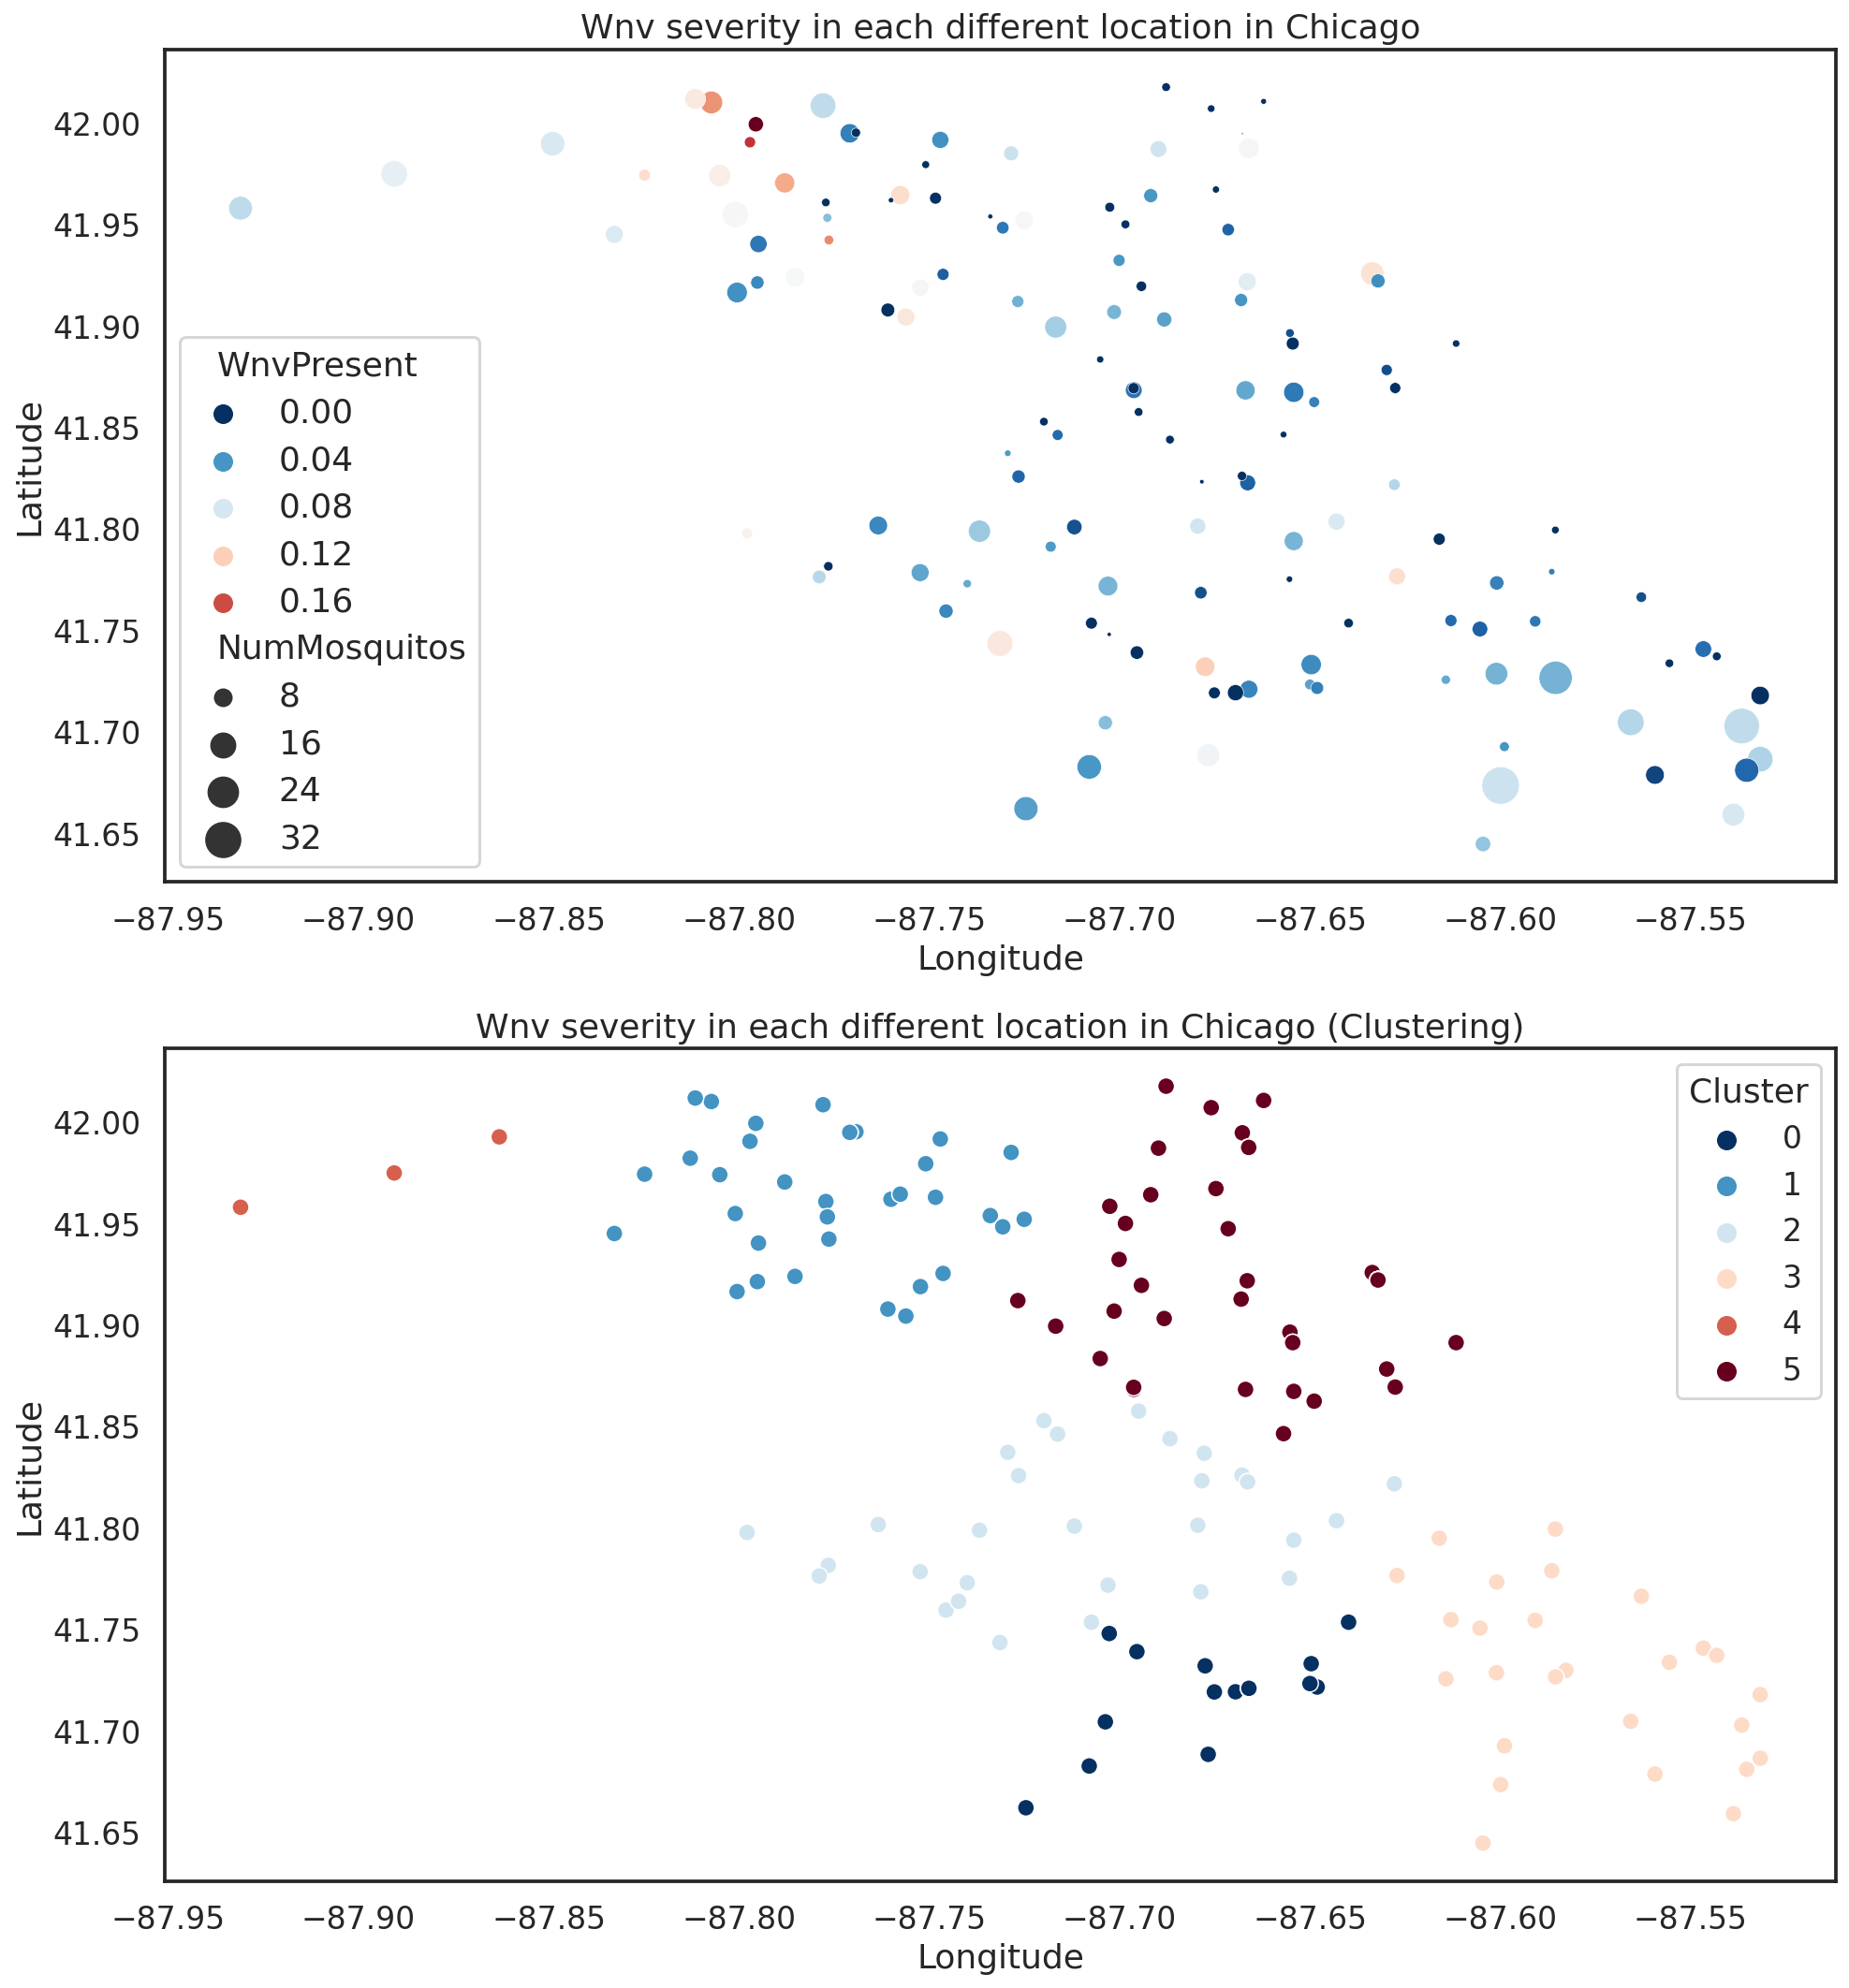

In [ ]:
#Clustering vs Original data 

fig, axes = plt.subplots(2,1,figsize= (16,18))
# plt.figure(figsize=(16,9))
plt.subplot(2,1,1)
g = sns.scatterplot(data=df_merged.groupby('Trap').mean().sort_values(by='WnvPresent', ascending=False), y="Latitude", x="Longitude",
                    hue='WnvPresent', size = 'NumMosquitos' ,palette='RdBu_r', sizes = (1,400))

g.set_title('Wnv severity in each different location in Chicago');

plt.subplot(2,1,2)
g = sns.scatterplot(data=X_train, y="Latitude", x="Longitude",
                    hue='Cluster' ,palette='RdBu_r', )

g.set_title('Wnv severity in each different location in Chicago (Clustering)');



## Train-test split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42,stratify=y)

In [ ]:
y_train.value_counts(normalize=True)

0    0.947525
1    0.052475
Name: WnvPresent, dtype: float64

In [ ]:
y_val.value_counts(normalize=True)

0    0.947669
1    0.052331
Name: WnvPresent, dtype: float64

## Standardize and One-hot Encoding

### Training set

In [ ]:
# OneHotEncoding Species Attribute
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
ohe_columns = ['Species', 'WeeksOfYear', 'Month','Trap',
                'days_since_last_rain', 'WindSpeed_bin','10ewm_RH_bin']

enc.fit(X_train[ohe_columns])
X_train_enc = pd.DataFrame(enc.transform(X_train[ohe_columns]),
                           columns=enc.get_feature_names(X_train[ohe_columns].columns))
# Standardize
ss = StandardScaler()
ss.fit(X_train.drop(columns=ohe_columns))
X_train_sc = ss.transform(X_train.drop(columns=ohe_columns))
X_train_sc = pd.DataFrame(
    X_train_sc, columns=X_train.drop(columns=ohe_columns).columns)


# Concatanate numerical and categorical columns
X_train_prep = pd.concat([X_train_sc, X_train_enc], axis=1)

### Validation set

In [ ]:
X_val_enc = pd.DataFrame(enc.transform(X_val[ohe_columns]), 
                      columns = enc.get_feature_names(X_val[ohe_columns].columns))
#Standardize
X_val_sc = ss.transform(X_val.drop(columns=ohe_columns))
X_val_sc = pd.DataFrame(X_val_sc, columns = X_val.drop(columns=ohe_columns).columns)


#Concatanate numerical and categorical columns
X_val_prep = pd.concat([X_val_sc,X_val_enc],axis = 1)

### Testing set

In [ ]:
X_test_enc = pd.DataFrame(enc.transform(X_test[ohe_columns]), 
                      columns = enc.get_feature_names(X_test[ohe_columns].columns))
#Standardize
X_test_sc = ss.transform(X_test.drop(columns=ohe_columns))
X_test_sc = pd.DataFrame(X_test_sc, columns = X_test.drop(columns=ohe_columns).columns)


#Concatanate numerical and categorical columns
X_test_prep = pd.concat([X_test_sc,X_test_enc],axis = 1)
# X_test_prep = pd.concat([X_test.drop(columns=['Species','Cluster','WeeksOfYear']),X_test_enc],axis = 1)



## SMOTE to handling imbalance class problem

In [ ]:
sm = SMOTE()
Xsm_train, ysm_train = sm.fit_resample(X_train_prep,y_train)
Xsm_train = Xsm_train.sample(frac=1, random_state=42)
ysm_train = ysm_train.sample(frac=1, random_state=42)

In [ ]:
print(Xsm_train.shape)
print(ysm_train.shape)
print(X_val_prep.shape)
print(y_val.shape)
print(X_test_prep.shape)

(15926, 215)
(15926,)
(2102, 215)
(2102,)
(116293, 215)


In [ ]:
Xsm_train.head()

,Latitude,Longitude,Tavg,Tdiff,Tmax,Tmin,DewPoint,WetBulb,ResultSpeed,%RH,10ewm_Tavg,10ewm_Tdiff,10ewm_Tmax,10ewm_Tmin,10ewm_DewPoint,10ewm_WetBulb,metar_BR,metar_DZ,metar_FG,metar_HZ,metar_RA,metar_TS,metar_TSRA,Cluster,Species_CULEX ERRATICUS,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,WeeksOfYear_22,WeeksOfYear_23,WeeksOfYear_24,WeeksOfYear_25,WeeksOfYear_26,WeeksOfYear_27,WeeksOfYear_28,WeeksOfYear_29,WeeksOfYear_30,...,Trap_T222,Trap_T223,Trap_T224,Trap_T225,Trap_T226,Trap_T227,Trap_T228,Trap_T229,Trap_T230,Trap_T231,Trap_T232,Trap_T233,Trap_T235,Trap_T236,Trap_T237,Trap_T238,Trap_T900,Trap_T903,days_since_last_rain_0.0,days_since_last_rain_1.0,days_since_last_rain_2.0,days_since_last_rain_3.0,days_since_last_rain_4.0,days_since_last_rain_5.0,days_since_last_rain_6.0,days_since_last_rain_7.0,days_since_last_rain_8.0,days_since_last_rain_9.0,days_since_last_rain_10.0,days_since_last_rain_11.0,days_since_last_rain_14.0,WindSpeed_bin_1,WindSpeed_bin_2,WindSpeed_bin_3,WindSpeed_bin_4,WindSpeed_bin_5,10ewm_RH_bin_1,10ewm_RH_bin_2,10ewm_RH_bin_3,10ewm_RH_bin_4
6126,0.993733,-1.032890,-0.289319,1.155442,0.129952,-0.654283,0.165235,0.045829,1.099480,0.835084,0.520628,1.656498,0.866116,0.158419,0.216586,0.410185,-0.634089,-0.146678,-0.107495,-0.358269,-0.620092,-0.293853,-0.437857,-1.029265,0.0,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7093,0.979394,-0.783621,1.042101,0.773153,1.216751,0.794205,1.183206,0.940930,0.064183,0.353984,0.295721,3.670697,1.037819,-0.449690,-0.710952,-0.207540,1.577066,-0.146678,-0.107495,2.791200,-0.620092,-0.293853,2.283851,-1.029265,0.0,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1659,1.131188,-0.898990,0.376391,1.346587,0.733729,-0.127560,-0.216503,0.045829,2.410856,-1.089317,0.411760,0.055104,0.441934,0.380567,0.566326,0.534357,-0.634089,-0.146678,-0.107495,-0.358269,-0.620092,-0.293853,-0.437857,-1.029265,0.0,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
15727,-0.090576,-0.245799,-0.023035,-1.329438,-0.473826,0.399163,0.801467,0.429444,-1.178174,1.556735,0.397925,-0.449494,0.286244,0.430552,0.040907,-2.295257,-0.634089,-0.146678,-0.107495,-0.358269,1.612664,-0.293853,-0.437857,-0.260033,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9682,1.426676,-0.886786,1.175243,0.199719,1.095996,1.057567,1.692191,1.452416,0.098692,1.075635,0.290765,-0.503987,0.165479,0.341516,0.572216,0.474724,1.577066,-0.146678,-0.107495,-0.358269,1.612664,-0.293853,-0.437857,-1.029265,0.0,0.496929,0.503071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


Right now, we'll have 3 different dataset for different purpose ...

1. SMOTE-Oversampling training set **(Xsm_train, ysm_train)** for model training
1. Validation set **(X_val_prep, y_val)** for model tuning
1. Testing set **(X_test_prep)** for submission

## Full Data (Lag)

In [ ]:
!gdown --id 1WKzCCvb43oULvV2j9tAJQCu2Om5mXIIy
!gdown --id 1wMwl_dOA7TKJS2FwXJRkvaYyiD_2Mdbs
!gdown --id 1ttzbZNWHRd-cqoF1fborNwdeFbK5iSm9

Downloading...
From: https://drive.google.com/uc?id=1WKzCCvb43oULvV2j9tAJQCu2Om5mXIIy
To: /content/X_test_prep_lag10.csv
56.0MB [00:02, 27.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wMwl_dOA7TKJS2FwXJRkvaYyiD_2Mdbs
To: /content/Xsm_train_lag10.csv
9.79MB [00:00, 37.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ttzbZNWHRd-cqoF1fborNwdeFbK5iSm9
To: /content/ysm_train_lag10.csv
100% 148k/148k [00:00<00:00, 1.31MB/s]


In [ ]:
Xsm_train_lag10 = pd.read_csv('/content/Xsm_train_lag10.csv')
ysm_train_lag10 = pd.read_csv('/content/ysm_train_lag10.csv')
X_test_prep_lag10 = pd.read_csv('/content/X_test_prep_lag10.csv')

In [ ]:
Xsm_train_lag10 = Xsm_train_lag10.drop(columns=['Unnamed: 0'])
ysm_train_lag10 = ysm_train_lag10.drop(columns=['Unnamed: 0'])
X_test_prep_lag10 = X_test_prep_lag10.drop(columns=['Unnamed: 0'])

In [ ]:
print(Xsm_train_lag10.shape)
print(ysm_train_lag10.shape)
print(X_test_prep_lag10.shape)

(19910, 64)
(19910, 1)
(116293, 64)


In [ ]:
Xsm_train_lag10.head()

,Tavg,Tdiff,ResultSpeed,%RH,10ewm_Tdiff,10ewm_Tmax,10ewm_Tmin,metar_BR,metar_DZ,metar_FG,metar_HZ,metar_RA,metar_TS,metar_TSRA,Species_CULEX ERRATICUS,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,WeeksOfYear_22,WeeksOfYear_23,WeeksOfYear_24,WeeksOfYear_25,WeeksOfYear_26,WeeksOfYear_27,WeeksOfYear_28,WeeksOfYear_29,WeeksOfYear_30,WeeksOfYear_31,WeeksOfYear_32,WeeksOfYear_33,WeeksOfYear_34,WeeksOfYear_35,WeeksOfYear_36,WeeksOfYear_37,WeeksOfYear_38,WeeksOfYear_39,WeeksOfYear_40,WeeksOfYear_41,days_since_last_rain_0.0,days_since_last_rain_1.0,days_since_last_rain_2.0,days_since_last_rain_3.0,days_since_last_rain_4.0,days_since_last_rain_5.0,days_since_last_rain_6.0,days_since_last_rain_7.0,days_since_last_rain_8.0,days_since_last_rain_9.0,days_since_last_rain_10.0,days_since_last_rain_11.0,days_since_last_rain_14.0,10ewm_RH_bin_1,10ewm_RH_bin_2,10ewm_RH_bin_3,10ewm_RH_bin_4
0,0.095626,-0.152084,0.786762,-0.802438,0.008517,1.949782,1.779958,-0.624393,-0.145908,-0.10658,-0.348021,-0.60587,-0.307576,-0.439221,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.496365,-0.346486,-0.828698,1.590255,-0.822394,1.165336,1.366379,1.601556,-0.145908,-0.10658,-0.348021,-0.60587,-0.307576,-0.439221,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.171532,0.625526,0.099332,-1.041707,0.052259,1.840518,1.664044,-0.624393,-0.145908,-0.10658,-0.348021,-0.60587,-0.307576,-0.439221,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.141316,0.0,0.0,0.0,0.858684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.438691,-0.735291,1.096106,-1.280976,-0.756226,-0.483895,-0.166031,-0.624393,-0.145908,-0.10658,-0.348021,-0.60587,-0.307576,-0.439221,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-1.240168,-1.901706,0.889877,1.111716,0.428646,-1.149245,-1.207703,-0.624393,-0.145908,-0.10658,-0.348021,-0.60587,-0.307576,-0.439221,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
Xsm_train_lag10.columns

Index(['Tavg', 'Tdiff', 'ResultSpeed', '%RH', '10ewm_Tdiff', '10ewm_Tmax',
       '10ewm_Tmin', 'metar_BR', 'metar_DZ', 'metar_FG', 'metar_HZ',
       'metar_RA', 'metar_TS', 'metar_TSRA', 'Species_CULEX ERRATICUS',
       'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS',
       'Species_CULEX RESTUANS', 'Species_CULEX SALINARIUS',
       'Species_CULEX TARSALIS', 'Species_CULEX TERRITANS', 'Cluster_0',
       'Cluster_1', 'Cluster_2', 'Cluster_3', 'Cluster_4', 'Cluster_5',
       'WeeksOfYear_22', 'WeeksOfYear_23', 'WeeksOfYear_24', 'WeeksOfYear_25',
       'WeeksOfYear_26', 'WeeksOfYear_27', 'WeeksOfYear_28', 'WeeksOfYear_29',
       'WeeksOfYear_30', 'WeeksOfYear_31', 'WeeksOfYear_32', 'WeeksOfYear_33',
       'WeeksOfYear_34', 'WeeksOfYear_35', 'WeeksOfYear_36', 'WeeksOfYear_37',
       'WeeksOfYear_38', 'WeeksOfYear_39', 'WeeksOfYear_40', 'WeeksOfYear_41',
       'days_since_last_rain_0.0', 'days_since_last_rain_1.0',
       'days_since_last_rain_2.0', 'days_since_last_ra

## Full Data (Maybe)

In [ ]:
!gdown --id 1JppVl652nBeskST1hnt8fP41suMnu4jm
!gdown --id 13SivXiA9BfkSD9TDzU3897aRZpUPx2AA
!gdown --id 1CPOE8qoj_yE6fYbwGzL-h71kRL35-wzm

Downloading...
From: https://drive.google.com/uc?id=1JppVl652nBeskST1hnt8fP41suMnu4jm
To: /content/Xsm_train_final_maybe.csv
25.1MB [00:00, 153MB/s]
Downloading...
From: https://drive.google.com/uc?id=13SivXiA9BfkSD9TDzU3897aRZpUPx2AA
To: /content/ysm_train_final_maybe.csv
100% 148k/148k [00:00<00:00, 38.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CPOE8qoj_yE6fYbwGzL-h71kRL35-wzm
To: /content/Xtest_train_final_maybe.csv
145MB [00:00, 173MB/s]


In [ ]:
Xsm_train_final_maybe = pd.read_csv('/content/Xsm_train_final_maybe.csv')
ysm_train_final_maybe = pd.read_csv('/content/ysm_train_final_maybe.csv')
Xtest_train_final_maybe = pd.read_csv('/content/Xtest_train_final_maybe.csv')

In [ ]:
Xsm_train_final_maybe = Xsm_train_final_maybe.drop(columns=['Unnamed: 0'])
ysm_train_final_maybe = ysm_train_final_maybe.drop(columns=['Unnamed: 0'])
Xtest_train_final_maybe = Xtest_train_final_maybe.drop(columns=['Unnamed: 0'])

In [ ]:
print(Xsm_train_final_maybe.shape)
print(ysm_train_final_maybe.shape)
print(Xtest_train_final_maybe.shape)

(19910, 215)
(19910, 1)
(116293, 215)


In [ ]:
Xsm_train_final_maybe.head()

,Latitude,Longitude,Tavg,Tdiff,Tmax,Tmin,DewPoint,WetBulb,ResultSpeed,%RH,10ewm_Tavg,10ewm_Tdiff,10ewm_Tmax,10ewm_Tmin,10ewm_DewPoint,10ewm_WetBulb,metar_BR,metar_DZ,metar_FG,metar_HZ,metar_RA,metar_TS,metar_TSRA,Cluster,Species_CULEX ERRATICUS,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,WeeksOfYear_22,WeeksOfYear_23,WeeksOfYear_24,WeeksOfYear_25,WeeksOfYear_26,WeeksOfYear_27,WeeksOfYear_28,WeeksOfYear_29,WeeksOfYear_30,...,Trap_T222,Trap_T223,Trap_T224,Trap_T225,Trap_T226,Trap_T227,Trap_T228,Trap_T229,Trap_T230,Trap_T231,Trap_T232,Trap_T233,Trap_T235,Trap_T236,Trap_T237,Trap_T238,Trap_T900,Trap_T903,days_since_last_rain_0.0,days_since_last_rain_1.0,days_since_last_rain_2.0,days_since_last_rain_3.0,days_since_last_rain_4.0,days_since_last_rain_5.0,days_since_last_rain_6.0,days_since_last_rain_7.0,days_since_last_rain_8.0,days_since_last_rain_9.0,days_since_last_rain_10.0,days_since_last_rain_11.0,days_since_last_rain_14.0,10ewm_RH_bin_1,10ewm_RH_bin_2,10ewm_RH_bin_3,10ewm_RH_bin_4,WindSpeed_bin_1,WindSpeed_bin_2,WindSpeed_bin_3,WindSpeed_bin_4,WindSpeed_bin_5
0,-0.664714,1.419745,0.108245,-0.178877,0.008605,0.133017,-0.338572,-0.082809,0.786180,-0.833453,1.628222,-0.089812,1.947250,1.805743,1.986917,1.971514,-0.626307,-0.146247,-0.105201,-0.357234,-0.610863,-0.291346,-0.433347,0.209723,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.296461,-0.076873,0.641151,0.011894,0.612073,0.660369,0.682026,0.563737,-0.591960,0.128297,-0.188995,0.475502,-0.138826,-0.306940,-0.600219,-0.886806,1.596660,-0.146247,9.505605,2.799285,-0.610863,-0.291346,-0.433347,1.086639,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.196506,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-1.522297,1.556466,0.907604,0.393435,0.974154,0.792207,1.319899,1.080975,-0.281879,0.849610,1.305844,-0.595864,1.173129,1.293681,1.630866,1.484260,1.596660,-0.146247,-0.105201,-0.357234,1.637028,-0.291346,2.307619,0.209723,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.964116,0.015035,-0.424661,-0.751189,-0.594864,-0.130658,-1.104020,-0.729356,1.096261,-1.314328,-0.278088,-0.820164,-0.480104,-0.125238,-0.338429,-0.196642,-0.626307,-0.146247,-0.105201,-0.357234,-0.610863,-0.291346,-0.433347,1.453149,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.999185,1.025235,-1.224020,-1.895814,-1.681106,-0.526172,-0.593722,-0.729356,0.889540,1.090047,-1.156049,0.311423,-1.143726,-1.158875,-1.192767,-1.069419,-0.626307,-0.146247,-0.105201,-0.357234,-0.610863,-0.291346,-0.433347,0.209723,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
columns_pca = [i for i in Xsm_train_final_maybe.columns][24:]

In [ ]:
from sklearn.decomposition import PCA

## PCA

In [ ]:
### Separate features into PCA

Xsm_train_final_maybe_pca = Xsm_train_final_maybe[columns_pca]
Xtest_train_final_maybe_pca = Xtest_train_final_maybe[columns_pca]

In [ ]:
pca = PCA()
X_pca = pca.fit_transform(Xsm_train_final_maybe_pca)

In [ ]:
exp_variance = pca.explained_variance_ratio_
exp_variance

array([1.01070110e-01, 9.62295963e-02, 7.32583074e-02, 6.95243514e-02,
       5.58016895e-02, 5.36725516e-02, 3.72477260e-02, 3.28406626e-02,
       3.14669874e-02, 2.74315061e-02, 2.57175969e-02, 2.40258531e-02,
       2.19194207e-02, 2.08632188e-02, 1.93969004e-02, 1.63032747e-02,
       1.57471555e-02, 1.38944603e-02, 1.29238803e-02, 1.17146001e-02,
       1.15257763e-02, 1.10320958e-02, 8.72618842e-03, 7.71837539e-03,
       7.61434102e-03, 6.66132305e-03, 5.59345184e-03, 5.51765628e-03,
       4.88520718e-03, 4.48916929e-03, 4.17151861e-03, 3.89224240e-03,
       3.82611852e-03, 3.26668467e-03, 3.06820129e-03, 2.99544633e-03,
       2.84208694e-03, 2.73885917e-03, 2.66500743e-03, 2.64077833e-03,
       2.56107163e-03, 2.51586651e-03, 2.50089504e-03, 2.44784969e-03,
       2.36189507e-03, 2.29221211e-03, 2.21466923e-03, 2.19527473e-03,
       2.18664840e-03, 2.17855782e-03, 2.16177051e-03, 2.11187635e-03,
       2.07579153e-03, 2.04610727e-03, 1.99015338e-03, 1.96096230e-03,
      

In [ ]:
np.cumsum(pca.explained_variance_ratio_)

array([0.10107011, 0.19729971, 0.27055801, 0.34008236, 0.39588405,
       0.44955661, 0.48680433, 0.51964499, 0.55111198, 0.57854349,
       0.60426108, 0.62828694, 0.65020636, 0.67106958, 0.69046648,
       0.70676975, 0.72251691, 0.73641137, 0.74933525, 0.76104985,
       0.77257562, 0.78360772, 0.79233391, 0.80005228, 0.80766663,
       0.81432795, 0.8199214 , 0.82543906, 0.83032426, 0.83481343,
       0.83898495, 0.84287719, 0.84670331, 0.84997   , 0.8530382 ,
       0.85603365, 0.85887573, 0.86161459, 0.8642796 , 0.86692038,
       0.86948145, 0.87199732, 0.87449821, 0.87694606, 0.87930795,
       0.88160017, 0.88381484, 0.88601011, 0.88819676, 0.89037532,
       0.89253709, 0.89464896, 0.89672476, 0.89877086, 0.90076102,
       0.90272198, 0.90466523, 0.90659743, 0.90849034, 0.91035958,
       0.91220434, 0.91399242, 0.91575564, 0.91749183, 0.91919767,
       0.92089019, 0.92256744, 0.92419398, 0.92580583, 0.92739777,
       0.92894308, 0.93046388, 0.93197025, 0.93346606, 0.93495

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Number of Components')

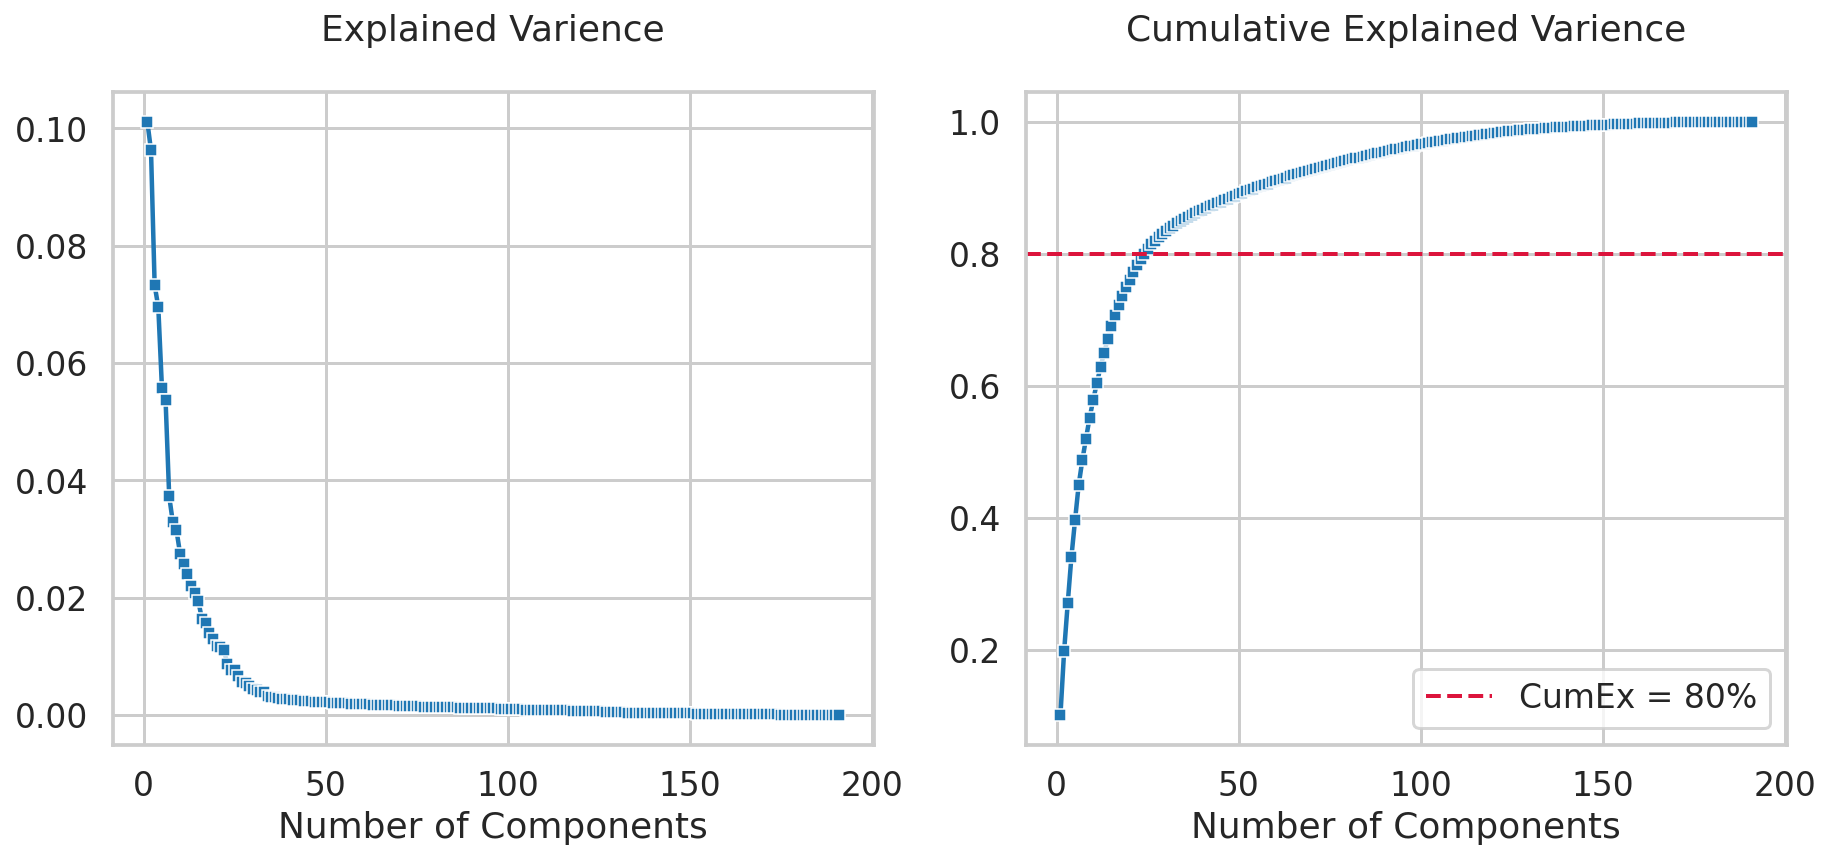

In [ ]:
### Suitable number of components = 15 (Cumulative Explained Varience > 95%)

sns.set_style('whitegrid')
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,6))
x = list(range(1, len(exp_variance)+1));
ax1 = sns.lineplot(x, exp_variance, marker = 's', markersize=6, ax=ax1);
ax2 = sns.lineplot(x, np.cumsum(exp_variance), marker = 's', markersize=6, ax=ax2);
ax2.axhline(0.80,ls='--',lw=2,c='crimson',label='CumEx = 80%')
ax2.legend()
#plt.xticks(x);
ax1.set_title('Explained Varience\n');
ax1.set_xlabel('Number of Components')
ax2.set_title('Cumulative Explained Varience\n');
ax2.set_xlabel('Number of Components')

In [ ]:
df_pca = ysm_train_lag10.copy()
df_pca['pca1'] = X_pca[:,0]
df_pca['pca2'] = X_pca[:,1]
df_pca['pca3'] = X_pca[:,2]
df_pca['pca4'] = X_pca[:,3]

NameError: ignored

In [ ]:
df_pca.head()

NameError: ignored

In [ ]:
### Example plot only between PCA1 and PCA2

plt.figure(figsize=(12,7))
sns.distplot(df_pca['pca1'])
sns.distplot(df_pca['pca2'])

NameError: ignored

<Figure size 864x504 with 0 Axes>

In [ ]:
### From Cumulative Explained Varience >95% --> n_components = 15

pca2 = PCA(n_components=20,random_state=1)
X_pca2_train = pca2.fit_transform(Xsm_train_final_maybe_pca)
X_pca2_test = pca2.transform(Xtest_train_final_maybe_pca)

In [ ]:
column_pca = ['pca'+str(i) for i in range(1,21)]

X_pca2_train = pd.DataFrame(X_pca2_train, columns = column_pca)
X_pca2_test = pd.DataFrame(X_pca2_test, columns = column_pca)

X_pca2_train.head()

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15,pca16,pca17,pca18,pca19,pca20
0,-0.416485,-0.168248,-0.250719,-1.199906,0.542583,0.399029,0.340442,-0.214887,-0.188297,-0.575056,0.238329,-0.042583,0.060814,-0.442533,0.354964,-0.184971,-0.659812,0.236225,0.298257,0.231493
1,0.855075,0.800596,-0.549965,-0.627776,-0.169069,-0.209742,-0.199528,-0.457184,-0.048119,-0.240563,-0.248501,-0.020220,0.878917,0.635866,-0.234066,0.024201,0.120699,0.265225,-0.331892,0.027690
2,-1.401043,0.473590,0.790271,0.321264,-0.150397,-0.261741,-0.114250,0.114745,-0.178237,0.099144,-0.039785,0.153689,0.132630,0.021062,-0.187742,-0.079055,-0.110191,-0.192399,0.062926,-0.140754
3,0.181444,-0.966370,-0.061561,-0.728278,0.156416,0.874677,0.408701,0.031331,-0.658842,0.524055,-0.564628,0.303707,-0.288548,-0.349078,-0.063616,-0.413166,-0.019120,0.088178,-0.184745,-0.231317
4,0.935928,-0.324948,0.495575,0.158848,0.832715,0.794535,0.278091,-0.559182,1.005151,0.591789,-0.401771,0.073066,0.006061,-0.239511,-0.503826,0.114796,-0.306076,0.144797,0.096392,0.122765


In [ ]:
print(X_pca2_train.shape)
print(X_pca2_test.shape)

(19910, 20)
(116293, 20)


In [ ]:
X_pca2_train = pd.concat([Xsm_train_final_maybe.drop(columns = columns_pca), X_pca2_train],axis=1)
X_pca2_test = pd.concat([Xtest_train_final_maybe.drop(columns = columns_pca), X_pca2_test],axis=1)

In [ ]:
print(X_pca2_train.shape)
print(X_pca2_test.shape)

(19910, 44)
(116293, 44)


In [ ]:
X_pca2_train.head()

,Latitude,Longitude,Tavg,Tdiff,Tmax,Tmin,DewPoint,WetBulb,ResultSpeed,%RH,10ewm_Tavg,10ewm_Tdiff,10ewm_Tmax,10ewm_Tmin,10ewm_DewPoint,10ewm_WetBulb,metar_BR,metar_DZ,metar_FG,metar_HZ,metar_RA,metar_TS,metar_TSRA,Cluster,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15,pca16,pca17,pca18,pca19,pca20
0,-0.664714,1.419745,0.108245,-0.178877,0.008605,0.133017,-0.338572,-0.082809,0.786180,-0.833453,1.628222,-0.089812,1.947250,1.805743,1.986917,1.971514,-0.626307,-0.146247,-0.105201,-0.357234,-0.610863,-0.291346,-0.433347,0.209723,-0.416485,-0.168248,-0.250719,-1.199906,0.542583,0.399029,0.340442,-0.214887,-0.188297,-0.575056,0.238329,-0.042583,0.060814,-0.442533,0.354964,-0.184971,-0.659812,0.236225,0.298257,0.231493
1,0.296461,-0.076873,0.641151,0.011894,0.612073,0.660369,0.682026,0.563737,-0.591960,0.128297,-0.188995,0.475502,-0.138826,-0.306940,-0.600219,-0.886806,1.596660,-0.146247,9.505605,2.799285,-0.610863,-0.291346,-0.433347,1.086639,0.855075,0.800596,-0.549965,-0.627776,-0.169069,-0.209742,-0.199528,-0.457184,-0.048119,-0.240563,-0.248501,-0.020220,0.878917,0.635866,-0.234066,0.024201,0.120699,0.265225,-0.331892,0.027690
2,-1.522297,1.556466,0.907604,0.393435,0.974154,0.792207,1.319899,1.080975,-0.281879,0.849610,1.305844,-0.595864,1.173129,1.293681,1.630866,1.484260,1.596660,-0.146247,-0.105201,-0.357234,1.637028,-0.291346,2.307619,0.209723,-1.401043,0.473590,0.790271,0.321264,-0.150397,-0.261741,-0.114250,0.114745,-0.178237,0.099144,-0.039785,0.153689,0.132630,0.021062,-0.187742,-0.079055,-0.110191,-0.192399,0.062926,-0.140754
3,0.964116,0.015035,-0.424661,-0.751189,-0.594864,-0.130658,-1.104020,-0.729356,1.096261,-1.314328,-0.278088,-0.820164,-0.480104,-0.125238,-0.338429,-0.196642,-0.626307,-0.146247,-0.105201,-0.357234,-0.610863,-0.291346,-0.433347,1.453149,0.181444,-0.966370,-0.061561,-0.728278,0.156416,0.874677,0.408701,0.031331,-0.658842,0.524055,-0.564628,0.303707,-0.288548,-0.349078,-0.063616,-0.413166,-0.019120,0.088178,-0.184745,-0.231317
4,-0.999185,1.025235,-1.224020,-1.895814,-1.681106,-0.526172,-0.593722,-0.729356,0.889540,1.090047,-1.156049,0.311423,-1.143726,-1.158875,-1.192767,-1.069419,-0.626307,-0.146247,-0.105201,-0.357234,-0.610863,-0.291346,-0.433347,0.209723,0.935928,-0.324948,0.495575,0.158848,0.832715,0.794535,0.278091,-0.559182,1.005151,0.591789,-0.401771,0.073066,0.006061,-0.239511,-0.503826,0.114796,-0.306076,0.144797,0.096392,0.122765


# Evaluate Model

In [ ]:
### SVM 
svc = SVC(C=200,kernel = 'poly',degree = 4, random_state=1)
svc.fit(Xsm_train, ysm_train)
pred_svc = svc.predict(X_val_prep)

### Logistic Regression
lgr = LogisticRegression(C=200,random_state=42)
lgr.fit(Xsm_train, ysm_train)
pred_lgr = lgr.predict(X_val_prep)

### Decision Tree
tree = DecisionTreeClassifier(criterion="gini", max_depth=None,random_state=42)
tree.fit(Xsm_train, ysm_train)
pred_tree = tree.predict(X_val_prep)

### Random Forest
clf = RandomForestClassifier(n_estimators=300,min_samples_split=11,min_samples_leaf=7, max_features=2,max_depth= 90,random_state=1)
clf.fit(Xsm_train, ysm_train)
pred_clf = clf.predict(X_val_prep)

### XGBoost
xgb =XGBClassifier(n_estimators=300, learning_rate=0.09, max_depth=6)
xgb.fit(Xsm_train, ysm_train)
pred_xgb = xgb.predict(X_val_prep)

In [ ]:
svm_auc = roc_auc_score(y_val,pred_svc)
lgr_auc = roc_auc_score(y_val,pred_lgr)
tree_auc = roc_auc_score(y_val,pred_tree)
clf_auc = roc_auc_score(y_val,pred_clf)
xgb_auc = roc_auc_score(y_val,pred_xgb)

In [ ]:
### Evaluate Model
print('\t\t\t\tSupport Vector Machine\n')

print(f'AUC score = {roc_auc_score(y_val,pred_svc)}')
print(f'f1 score = {f1_score(y_val,pred_svc)}')
print(f'Precision score = {precision_score(y_val,pred_svc)}')
print(f'Recall score = {recall_score(y_val,pred_svc)}')
print('')
print(classification_report(y_val,pred_svc))
print('----------------------------------------------------------')
print('')
print('')
print('\t\t\t\tLogistic Regression\n')

print(f'AUC score = {roc_auc_score(y_val,pred_lgr)}')
print(f'f1 score = {f1_score(y_val,pred_lgr)}')
print(f'Precision score = {precision_score(y_val,pred_lgr)}')
print(f'Recall score = {recall_score(y_val,pred_lgr)}')
print('')
print(classification_report(y_val,pred_lgr))
print('----------------------------------------------------------')
print('')
print('')
print('\t\t\t\tDecision Tree\n')

print(f'AUC score = {roc_auc_score(y_val,pred_tree)}')
print(f'f1 score = {f1_score(y_val,pred_tree)}')
print(f'Precision score = {precision_score(y_val,pred_tree)}')
print(f'Recall score = {recall_score(y_val,pred_tree)}')
print('')
print(classification_report(y_val,pred_tree))
print('----------------------------------------------------------')
print('')
print('')
print('\t\t\t\tRandom Forest\n')

print(f'AUC score = {roc_auc_score(y_val,pred_clf)}')
print(f'f1 score = {f1_score(y_val,pred_clf)}')
print(f'Precision score = {precision_score(y_val,pred_clf)}')
print(f'Recall score = {recall_score(y_val,pred_clf)}')
print('')
print(classification_report(y_val,pred_clf))
print('----------------------------------------------------------')
print('')
print('')
print('\t\t\t\tXGBoost\n')

print(f'AUC score = {roc_auc_score(y_val,pred_xgb)}')
print(f'f1 score = {f1_score(y_val,pred_xgb)}')
print(f'Precision score = {precision_score(y_val,pred_xgb)}')
print(f'Recall score = {recall_score(y_val,pred_xgb)}')
print('')
print(classification_report(y_val,pred_xgb))
print('----------------------------------------------------------')

In [ ]:
### Visualization

names = ['SVM','Logistic Regression','Decision Tree','Random Forest','XGBoost']
scores = [svm_auc,lgr_auc,tree_auc,clf_auc,xgb_auc]

df_score = pd.DataFrame({'names':names,'scores':scores}).set_index('names')

In [ ]:
df_score

In [ ]:
plt.figure(figsize=(10,7))
sns.barplot(data = df_score, x = names, y=scores)
plt.axhline(0.7,ls='--',color = 'salmon')
plt.xticks(rotation=60);
plt.title('AUC Score in each models\n')
plt.ylabel('Score')

In [ ]:
def model_score(ytest,prediction):
  print(f'AUC score = {roc_auc_score(ytest,prediction)}')
  print(f'f1 score = {f1_score(ytest,prediction)}')
  print(f'Precision score = {precision_score(ytest,prediction)}')
  print(f'Recall score = {recall_score(ytest,prediction)}')
  print(classification_report(ytest,prediction))

In [ ]:
def confusion_eval(y_test,prediction):
  tn, fp, fn, tp = confusion_matrix(y_test,prediction).ravel()
  
  print('All Data:', len(y_test))
  print('Correctly Predict that Wnv is Positive (TP):',tp)
  print('Correctly Predict that Wnv is Negative (TN):',tn)
  print('Incorrectly Predict that Wnv is Positive (FP):',fp)
  print('Incorrectly Predict that Wnv is Negative (FN):',fn)

In [ ]:
def confusion_score(y_test,prediction):
  tn, fp, fn, tp = confusion_matrix(y_test,prediction).ravel()
    
  print('Accuracy: {}'.format(round((tp+tn)/(tp+fp+tn+fn),4)))
  print('Misclassification rate: {}'.format(round((fp+fn)/(tp+fp+tn+fn),4)))
  print('Precision: {}'.format(round(tp/(tp+fp),4)))
  print('Recall: {}'.format(round(tp/(tp+fn),4)))
  print('Specificity: {}'.format(round(tn/(tn+fp),4)))

In [ ]:
def confustion_plot(model, Xtest, ytest):
  disp = plot_confusion_matrix(model, Xtest, ytest,cmap = plt.cm.viridis)
  plt.grid()
  plt.title('Evaluate Model\n')
  plt.xlabel('Prediction')
  plt.ylabel('Actual')
  print(disp)

# Models

## SVM

In [ ]:
svc = SVC(C=200,kernel = 'poly',degree = 4, random_state=42)
svc.fit(X_train_prep, y_train)

SVC(C=200, degree=4, kernel='poly', random_state=42)

In [ ]:
pred_svc = svc.predict(X_val_prep)
pred_svc[:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int64)

In [ ]:
svc.score(X_train_prep, y_train)

0.9613218174990612

In [ ]:
svc.score(X_val_prep, y_val)

0.9394394394394394

In [ ]:
accuracy_score(pred_svc, y_val)

0.9394394394394394

In [ ]:
model_score(y_val, pred_svc)

AUC score = 0.5423361976369495
f1 score = 0.14184397163120568
Precision score = 0.23255813953488372
Recall score = 0.10204081632653061


## SVM (SMOTE)

In [ ]:
svc2 = SVC(C=200,kernel = 'rbf', random_state=42)
svc2.fit(Xsm_train, ysm_train)

SVC(C=200, kernel='linear', random_state=42)

In [ ]:
pred_svc2 = svc2.predict(X_val_prep)
pred_svc2[:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1], dtype=int64)

In [ ]:
svc2.score(Xsm_train, ysm_train)

0.8183971575207264

In [ ]:
svc2.score(X_val_prep, y_val)

0.7552552552552553

In [ ]:
print(f'AUC score = {roc_auc_score(y_val, pred_svc2)}')
print(f'f1 score = {f1_score(y_val, pred_svc2)}')
print(f'Precision score = {precision_score(y_val, pred_svc2)}')
print(f'Recall score = {recall_score(y_val, pred_svc2)}')

AUC score = 0.7551825993555317
f1 score = 0.23233908948194665
Precision score = 0.137291280148423
Recall score = 0.7551020408163265


## SVM (SMOTE) >> Test

In [ ]:
pred_svc2 = svc2.predict(X_test_prep)
pred_svc2[:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int64)

In [ ]:
pred_svc2 = pd.DataFrame(pred_svc2).reset_index().rename(columns={'index':'Id',0:'WnvPresent'})
pred_svc2['Id'] = [i for i in range(1,len(pred_svc2)+1)]

In [ ]:
pred_svc2

,Id,WnvPresent
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
116288,116289,0
116289,116290,0
116290,116291,0
116291,116292,0


In [ ]:
pred_svc2.to_csv('pred_svc2_4.csv',index=False)

## SVM (SMOTE + PCA) >> Test

In [ ]:
svc3 = SVC(C=200,kernel = 'poly',degree=4, random_state=42, probability=True)
svc3.fit(X_pca2_train, ysm_train)

SVC(C=200, degree=4, kernel='poly', probability=True, random_state=42)

In [ ]:
pred_svc3 = svc3.predict_proba(X_pca2_test)
pred_svc3[:50]

array([[9.99999900e-01, 1.00000010e-07],
       [9.99999900e-01, 1.00000010e-07],
       [9.99999900e-01, 1.00000010e-07],
       [9.99999900e-01, 1.00000010e-07],
       [9.99999900e-01, 1.00000010e-07],
       [9.99999900e-01, 1.00000010e-07],
       [9.99999900e-01, 1.00000010e-07],
       [9.99999900e-01, 1.00000010e-07],
       [9.99999900e-01, 1.00000010e-07],
       [9.99999900e-01, 1.00000010e-07],
       [9.99999900e-01, 1.00000010e-07],
       [9.99999900e-01, 1.00000010e-07],
       [9.99999900e-01, 1.00000010e-07],
       [9.99999900e-01, 1.00000010e-07],
       [9.99999900e-01, 1.00000010e-07],
       [9.99999900e-01, 1.00000010e-07],
       [9.99999900e-01, 1.00000010e-07],
       [9.99999900e-01, 1.00000010e-07],
       [9.99999900e-01, 1.00000010e-07],
       [9.99999900e-01, 1.00000010e-07],
       [9.99999900e-01, 1.00000010e-07],
       [9.99999900e-01, 1.00000010e-07],
       [9.99999900e-01, 1.00000010e-07],
       [9.99999900e-01, 1.00000010e-07],
       [9.999999

In [ ]:
pred_svc3 = pd.DataFrame(pred_svc3).reset_index().rename(columns={'index':'Id',0:'NoWnv',1:'WnvPresent'})
pred_svc3['Id'] = [i for i in range(1,len(pred_svc3)+1)]
pred_svc3 = pred_svc3.drop(columns=['NoWnv'])

In [ ]:
pred_svc3

,Id,WnvPresent
0,1,1.000000e-07
1,2,1.000000e-07
2,3,1.000000e-07
3,4,1.000000e-07
4,5,1.000000e-07
...,...,...
116288,116289,1.000000e-07
116289,116290,1.000000e-07
116290,116291,1.000000e-07
116291,116292,1.000000e-07


In [ ]:
pred_svc3.to_csv('pred_svc3_4.csv',index=False)

## Logistic Regression

In [ ]:
lgr = LogisticRegression(C=200, random_state=42)
lgr.fit(X_train_prep, y_train)

LogisticRegression(C=200, random_state=42)

In [ ]:
pred_lgr = lgr.predict(X_val_prep)
pred_lgr[:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int64)

In [ ]:
lgr.score(X_train_prep, y_train)

0.9511828764551258

In [ ]:
lgr.score(X_val_prep, y_val)

0.950950950950951

In [ ]:
accuracy_score(pred_lgr, y_val)

0.950950950950951

In [ ]:
print(f'AUC score = {roc_auc_score(y_val, pred_lgr)}')
print(f'f1 score = {f1_score(y_val, pred_lgr)}')
print(f'Precision score = {precision_score(y_val, pred_lgr)}')
print(f'Recall score = {recall_score(y_val, pred_lgr)}')

AUC score = 0.5
f1 score = 0.0
Precision score = 0.0
Recall score = 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Logistic Regression (SMOTE)

In [ ]:
lgr2 = LogisticRegression(C=200,random_state=42)
lgr2.fit(Xsm_train, ysm_train)

LogisticRegression(C=200, random_state=42)

In [ ]:
pred_lgr2 = lgr2.predict(X_val_prep)
pred_lgr2[:50]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1], dtype=int64)

In [ ]:
lgr2.score(Xsm_train, ysm_train)

0.7731938412949072

In [ ]:
lgr2.score(X_val_prep, y_val)

0.7542542542542543

In [ ]:
accuracy_score(pred_lgr2, y_val)

0.7542542542542543

In [ ]:
print(f'AUC score = {roc_auc_score(y_val, pred_lgr2)}')
print(f'f1 score = {f1_score(y_val, pred_lgr2)}')
print(f'Precision score = {precision_score(y_val, pred_lgr2)}')
print(f'Recall score = {recall_score(y_val, pred_lgr2)}')

AUC score = 0.7836895810955962
f1 score = 0.24577572964669742
Precision score = 0.14466546112115733
Recall score = 0.8163265306122449


## Decision Tree (SMOTE)

In [ ]:
tree2 = DecisionTreeClassifier(criterion="gini", max_depth=None,random_state=42)
tree2.fit(Xsm_train, ysm_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
pred_tree2 = tree2.predict(X_val_prep)
pred_tree2[:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int64)

In [ ]:
tree2.score(Xsm_train, ysm_train)

0.981313330701408

In [ ]:
tree2.score(X_val_prep, y_val)

0.9014014014014013

In [ ]:
print(f'AUC score = {roc_auc_score(y_val, pred_tree2)}')
print(f'f1 score = {f1_score(y_val, pred_tree2)}')
print(f'Precision score = {precision_score(y_val, pred_tree2)}')
print(f'Recall score = {recall_score(y_val, pred_tree2)}')

AUC score = 0.623952738990333
f1 score = 0.23938223938223938
Precision score = 0.19254658385093168
Recall score = 0.3163265306122449


## Random Forest (SMOTE)

In [ ]:
clf2 = RandomForestClassifier(n_estimators=200,min_samples_split=11,min_samples_leaf=7, max_features=2,max_depth= 80,random_state=42)
clf2.fit(Xsm_train, ysm_train)

RandomForestClassifier(max_depth=80, max_features=2, min_samples_leaf=7,
                       min_samples_split=11, n_estimators=200, random_state=42)

In [ ]:
pred_clf2 = clf2.predict(X_val_prep)
pred_clf2[:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int64)

In [ ]:
clf2.score(Xsm_train, ysm_train)

0.9444005790235558

In [ ]:
clf2.score(X_val_prep, y_val)

0.8898898898898899

In [ ]:
print(f'AUC score = {roc_auc_score(y_val, pred_clf2)}')
print(f'f1 score = {f1_score(y_val, pred_clf2)}')
print(f'Precision score = {precision_score(y_val, pred_clf2)}')
print(f'Recall score = {recall_score(y_val, pred_clf2)}')

AUC score = 0.7485499462943072
f1 score = 0.3452380952380952
Precision score = 0.24369747899159663
Recall score = 0.5918367346938775


## Random Foreset (SMOTE) >> Test

In [ ]:
pred_clf2 = clf2.predict(X_test_prep)
pred_clf2[:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int64)

In [ ]:
pred_clf2 = pd.DataFrame(pred_clf2).reset_index().rename(columns={'index':'Id',0:'WnvPresent'})
pred_clf2['Id'] = [i for i in range(1,len(pred_clf2)+1)]

In [ ]:
pred_clf2.to_csv('pred_clf2.csv',index=False)

## Random Forest (SMOTE + PCA) >> Test

In [ ]:
clf3 = RandomForestClassifier(n_estimators=300,min_samples_split=11,min_samples_leaf=7, max_features=2,max_depth= 90,random_state=1)
clf3.fit(X_pca2_train, ysm_train_final_maybe)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(max_depth=90, max_features=2, min_samples_leaf=7,
                       min_samples_split=11, n_estimators=300, random_state=1)

In [ ]:
pred_clf3 = clf3.predict_proba(X_pca2_test)
pred_clf3[:20]

array([[0.90383209, 0.09616791],
       [0.93788025, 0.06211975],
       [0.88444316, 0.11555684],
       [0.92571081, 0.07428919],
       [0.92765526, 0.07234474],
       [0.92576372, 0.07423628],
       [0.92576372, 0.07423628],
       [0.92576372, 0.07423628],
       [0.91476671, 0.08523329],
       [0.93724182, 0.06275818],
       [0.89828575, 0.10171425],
       [0.93629737, 0.06370263],
       [0.93553221, 0.06446779],
       [0.93629737, 0.06370263],
       [0.93629737, 0.06370263],
       [0.93629737, 0.06370263],
       [0.91547438, 0.08452562],
       [0.94003297, 0.05996703],
       [0.89444139, 0.10555861],
       [0.93755761, 0.06244239]])

In [ ]:
pred_clf3 = pd.DataFrame(pred_clf3).reset_index().rename(columns={'index':'Id',0:'NoWnv',1:'WnvPresent'})
pred_clf3['Id'] = [i for i in range(1,len(pred_clf3)+1)]
pred_clf3 = pred_clf3.drop(columns=['NoWnv'])

In [ ]:
pred_clf3

,Id,WnvPresent
0,1,0.096168
1,2,0.062120
2,3,0.115557
3,4,0.074289
4,5,0.072345
...,...,...
116288,116289,0.082332
116289,116290,0.076716
116290,116291,0.079352
116291,116292,0.079352


In [ ]:
pred_clf3['WnvPresent'].unique()

array([0.09616791, 0.06211975, 0.11555684, ..., 0.08233217, 0.07671595,
       0.07935157])

In [ ]:
pred_clf3.to_csv('pred_clf3_61.csv',index=False) ### Best score clf3_46 >> pca =25 (_maybe)

## XGBoost (SMOTE)

In [ ]:
xgb2 =XGBClassifier(n_estimators=300, learning_rate=0.09, max_depth=6)
xgb2.fit(Xsm_train, ysm_train)

XGBClassifier(learning_rate=0.09, max_depth=6, n_estimators=300)

In [ ]:
pred_xgb2 = xgb2.predict(X_val_prep)
pred_xgb2[:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int64)

In [ ]:
xgb2.score(Xsm_train, ysm_train)

0.9707856296881169

In [ ]:
xgb2.score(X_val_prep, y_val)

0.91991991991992

In [ ]:
print(f'AUC score = {roc_auc_score(y_val, pred_xgb2)}')
print(f'f1 score = {f1_score(y_val, pred_xgb2)}')
print(f'Precision score = {precision_score(y_val, pred_xgb2)}')
print(f'Recall score = {recall_score(y_val, pred_xgb2)}')

AUC score = 0.6433673469387755
f1 score = 0.29203539823008845
Precision score = 0.2578125
Recall score = 0.336734693877551


# Model GridSearch

## Import Data

## SVM

In [ ]:
#gridsearch
svc_params = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 

svc_gs = GridSearchCV(SVC(), svc_params, refit = True, verbose = 3)
svc_gs.fit(Xsm_train, ysm_train)
svc_gs.best_params_

In [ ]:
svc_gs.score(Xsm_train, ysm_train)

In [ ]:
pred_svc_gs = svc_gs.predict_proba(X_test_prep)
pred_svc_gs

In [ ]:
pred_svc_gs_df = pd.DataFrame(pred_svc_gs).reset_index().rename(columns={'index':'Id',0:'NoWnv',1:'WnvPresent'})
pred_svc_gs_df['Id'] = [i for i in range(1,len(pred_svc_gs)+1)]
pred_svc_gs_df.drop('NoWnv',axis=1,inplace=True)
pred_svc_gs_df.head()

In [ ]:
pred_svc_gs_df.to_csv('pred_svc_gs_df.csv',index=False)

## Logistic Regression

In [ ]:
#gridsearch
lgr2_params = {
    'penalty' : ['l1', 'l2'],
    'solver' : ['liblinear'],
    'C' : np.logspace(-5, 0, 5),
    'class_weight' : ['balanced']}
 
lgr2_gs = GridSearchCV(lgr2, lgr2_params, refit = True, verbose = 3)
lgr2_gs.fit(Xsm_train, ysm_train)
lgr2_gs.best_params_

In [ ]:
lgr2_gs.score(Xsm_train, ysm_train)

In [ ]:
pred_lgr2_gs = lgr2_gs.predict_proba(X_test_prep)
pred_lgr2_gs

In [ ]:
pred_pred_lgr2_gs_df = pd.DataFrame(pred_lgr2_gs).reset_index().rename(columns={'index':'Id',0:'NoWnv',1:'WnvPresent'})
pred_pred_lgr2_gs_df['Id'] = [i for i in range(1,len(pred_lgr2_gs)+1)]
pred_pred_lgr2_gs_df.drop('NoWnv',axis=1,inplace=True)
pred_pred_lgr2_gs_df.head()

In [ ]:
pred_pred_lgr2_gs_df.to_csv('pred_tree2_gs_df.csv',index=False)

## Decision Tree

In [ ]:
#gridsearch
tree2_params =  {
    'max_depth': [2, 3, 5, 7, 10],
    'min_samples_split': [5, 10, 15, 20],
    'min_samples_leaf': [2, 3, 4, 5, 6, 7],
    'class_weight' : ['balanced']}
 
tree2_gs = GridSearchCV(tree2, tree2_params, refit = True, verbose = 3)
tree2_gs.fit(Xsm_train, ysm_train)
tree2_gs.best_params_

In [ ]:
tree2_gs.score(Xsm_train, ysm_train)

In [ ]:
pred_tree2_gs = tree2_gs.predict_proba(X_test_prep)
pred_tree2_gs

In [ ]:
pred_tree2_gs_df = pd.DataFrame(pred_tree2_gs).reset_index().rename(columns={'index':'Id',0:'NoWnv',1:'WnvPresent'})
pred_tree2_gs_df['Id'] = [i for i in range(1,len(pred_tree2_gs)+1)]
pred_tree2_gs_df.drop('NoWnv',axis=1,inplace=True)
pred_tree2_gs_df.head()

In [ ]:
pred_tree2_gs_df.to_csv('pred_tree2_gs_df.csv',index=False)

## Random Forest

In [ ]:
#gridsearch
clf2_params = {
    'n_estimators': [200],
    'min_samples_leaf': [7,9],
    'min_samples_split':[11,13],
    'max_features':[12,16,20],
    'max_depth':[80,90]}

clf2_gs = GridSearchCV(clf2, param_grid=clf2_params, cv=5)
clf2_gs.fit(Xsm_train, ysm_train)
clf2_gs.best_params_

In [ ]:
clf2_gs.score(Xsm_train, ysm_train)

In [ ]:
pred_clf2_gs = clf2_gs.predict_proba(X_test_prep)
pred_clf2_gs

In [ ]:
pred_clf2_gs_df = pd.DataFrame(pred_clf2_gs).reset_index().rename(columns={'index':'Id',0:'NoWnv',1:'WnvPresent'})
pred_clf2_gs_df['Id'] = [i for i in range(1,len(pred_clf2_gs)+1)]
pred_clf2_gs_df.drop('NoWnv',axis=1,inplace=True)
pred_clf2_gs_df.head()

In [ ]:
pred_clf2_gs_df.to_csv('pred_clf2_gs_df.csv',index=False)

## XGBoost

In [ ]:
#gridsearch
xgb2_params = {
    'max_depth': [3], 
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'n_estimators': [2000], 
    'learning_rate': [0.005],
    'reg_alpha': [0.01]}
 
xgb2_gs = GridSearchCV(xgb2, xgb2_params, refit = True, verbose = 3)
xgb2_gs.fit(Xsm_train, ysm_train)
xgb2_gs.best_params_

In [ ]:
xgb2_gs.score(Xsm_train, ysm_train)

In [ ]:
pred_xgb2_gs = xgb2_gs.predict_proba(X_test_prep) #use X_test_sc if error
pred_xgb2_gs

In [ ]:
pred_xgb2_gs_df = pd.DataFrame(pred_xgb2_gs).reset_index().rename(columns={'index':'Id',0:'NoWnv',1:'WnvPresent'})
pred_xgb2_gs_df['Id'] = [i for i in range(1,len(pred_xgb2_gs)+1)]
pred_xgb2_gs_df.drop('NoWnv',axis=1,inplace=True)
pred_xgb2_gs_df.head()

In [ ]:
pred_xgb2_gs_df.to_csv('pred_xgb2_gs_df.csv',index=False)

# Feature Importance

In [ ]:
importance = pd.DataFrame(clf3.feature_importances_,index = X_pca2_train.columns,columns = ['coef'])
importance.sort_values(by='coef',ascending=False)

,coef
pca2,0.049735
pca3,0.039329
pca9,0.038140
10ewm_DewPoint,0.037297
pca1,0.037113
pca7,0.034901
pca8,0.033169
pca6,0.032944
10ewm_Tmin,0.032120
10ewm_WetBulb,0.031857


In [ ]:
pc_importance = pd.concat([
           pd.Series(pca2.components_[1],name='PC2'),
           pd.Series(pca2.components_[2],name='PC3'),
           pd.Series(pca2.components_[8],name='PC9')
],axis=1,)
pc_importance.index = Xsm_train_final_maybe_pca.columns
pc_importance.head()

,PC2,PC3,PC9
Species_CULEX ERRATICUS,-0.000064,-0.000182,0.000143
Species_CULEX PIPIENS,0.290801,-0.068969,-0.301255
Species_CULEX PIPIENS/RESTUANS,-0.190713,-0.112936,-0.171959
Species_CULEX RESTUANS,-0.094561,0.172958,0.467108
Species_CULEX SALINARIUS,-0.002289,0.003818,0.000761


In [ ]:
pc_importance.sort_values(by='PC2',ascending=False).head(20)

,PC2,PC3,PC9
Month_8,0.572276,0.005647,0.061996
WindSpeed_bin_2,0.298214,-0.461377,0.039737
Species_CULEX PIPIENS,0.290801,-0.068969,-0.301255
10ewm_RH_bin_2,0.289691,0.179555,-0.028988
WeeksOfYear_33,0.232042,-0.085909,-0.000296
WeeksOfYear_34,0.148875,0.136256,0.015546
days_since_last_rain_0.0,0.115810,0.470718,0.177355
WeeksOfYear_31,0.067424,0.014676,0.073590
days_since_last_rain_7.0,0.059617,-0.085278,-0.027888
WeeksOfYear_35,0.059121,-0.104237,-0.055264
